# Elastic FWI with extrapolated low-frequencies

Here, we initialize the full-waveform inversion in a setup identical to the field data experiment and apply the trained **Multi-LCM** network to

* Predict low-frequency seismic data
* Predict intial model for inversion

Then we run elastic FWI from extrapolated data on Marmousi II benchmark model.

------
This notebook reproduces the workflow for generation of synthetic data from from 
**"Multi-task learning for low-frequency extrapolation and elastic model building from seismic data"**

by [Ovcharenko Oleg](https://ovcharenkoo.com/), [Vladimir Kazei](https://vkazei.com/), [Tariq Alkhalifah](https://sites.google.com/a/kaust.edu.sa/tariq/home) and [Daniel Peter](https://github.com/danielpeter), KAUST, Saudi Arabia, 2021

In [1]:
import os
import sys
import copy
import glob
import numpy as np
import importlib
import multiprocessing

import segyio
from scipy import signal, ndimage
from natsort import natsorted
from skimage.transform import rescale, resize

import utils.shared as sd
from utils.shared import Survey
import utils.loaders as ld
import utils.vis as vis

from IPython.display import clear_output

# remove the sys.path... line and add pyapi_denise.py to the same directory with the notebook
sys.path.append(os.path.abspath('../'))
import pyapi_denise as api
print(f'Python: {sys.prefix}')

Python: /home/ovcharoo/work/env_torch


In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 100,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [3]:
root_fwi = './pretrained_files/fwi_outputs/out_fwi_marm/'
path_to_model1 = './pretrained_files/trained_nets/ex5_multi_lcm/'

# Init Denise API

In [4]:
denise_root = '../den/'
d = api.Denise(denise_root, verbose=1)

Init Python 3 API for Denise-Black-Edition.
Check binary in ../den/bin/denise
Parse ../den/par/DENISE_marm_OBC.inp
Current directory is /home/ovcharoo/work/multilow
Init paths at ./outputs/


## Work directory
Where to output everything

In [5]:
d.save_folder = root_fwi
d.set_paths()

Current directory is /home/ovcharoo/work/multilow
Init paths at ./pretrained_files/fwi_outputs/out_fwi_marm/


# Get acquitision details

In [6]:
survey = sd.load_obj('./pretrained_files/data/survey.pkl')

src = survey.src
rec = survey.rec
vp = survey.vp
dx = survey.dx
wb_taper = survey.wb_taper
log_idx = survey.log_idx
bpw = survey.bpw
log_loc = survey.log_loc
dDT = survey.dDT
dNT = survey.dNT

# Alias for temporal sampling
dt = dDT
# print(survey)

Load obj from ./pretrained_files/data/survey.pkl


In [7]:
dsrc = np.mean(src.x[1:] - src.x[:-1])
print('Field data spacing between sources {:.2f} m'.format(dsrc))

Field data spacing between sources 150.00 m


### Load Marmousi II model

In [8]:
vp_baseline = vp.copy()
print(vp.shape)

marm_path = os.path.join(root_fwi, 'start/')
os.makedirs(marm_path, exist_ok=True)
print(marm_path)
if not 'marmousi_II_marine.vp' in os.listdir(marm_path):
    # Download Marmousi II model
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.rho -P {marm_path}')

    # Download initial model for FWI
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.rho -P {marm_path}')

def extend(x, ez, ex):
    if ex > 0:
        x = np.concatenate((x, np.flip(x[:, -ex:], -1)), 1)              # OX
    if ez > 0:
        x = np.concatenate((x, x.min() * np.ones((ez, x.shape[1]))), 0)  # OZ
    return x

def get_vp_vs_rho(vp):
    # Some model tuning
    # Add water
    vp = extend(vp, 15, 0)
    print(f'Reshape {vp.shape} into {wb_taper.shape}...')
    
    # Resize end extend
    vp = resize(vp, wb_taper.shape, anti_aliasing=True)
    vp = np.where(vp <= 1500.0, 1490.0, vp)
    vp = extend(vp, 0, 264 + 10 * 8)

    # Gardner's relation
    # https://www.subsurfwiki.org/wiki/Gardner%27s_equation
    # Density, [kg/m3] 
    rho = 1e3*0.3 * vp.copy()**0.25
    rho = np.where(vp < 1.01 * np.min(vp), 1000, rho)
    
    # Shear velocity, [m/s]
    vs = vp.copy() / (3 ** 0.5)
    vs = np.where(vp < 1.01 * np.min(vp), 0, vs)

    return vp, vs, rho

(152, 600)
./pretrained_files/fwi_outputs/out_fwi_marm/start/


### Re-scale to field survey dimensions

In [9]:
vp_marm = ld.load_bin(f'{marm_path}marmousi_II_marine.vp', (500, 174))[:, 100:]
print(vp_marm.min(), vp_marm.max())

# This is what was used in generation of training data
box_min = 1490.
box_max = 4000. 

vmin_marm = vp_marm.min()
vp_marm -= vmin_marm

vmax_marm = vp_marm.max()
vp_marm /= vmax_marm
vp_marm = box_min  + vp_marm * (box_max - box_min)
print(vp_marm.min(), vp_marm.max())

(174, 500)
1500.0 4766.604
1490.0 4000.0


### Make vs, rho form vp

Reshape (189, 400) into (152, 600)...
vp:	(152, 944), 1490.0000, 4000.0000 m/s

vs:	(152, 944), 0.0000, 2309.4011 m/s

rho:	(152, 944), 1000.0000, 2385.8122 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 23575.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


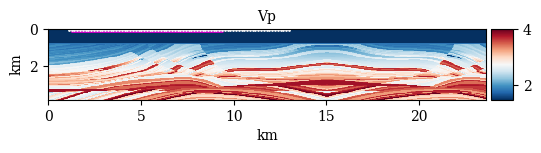

In [10]:
vp, vs, rho = get_vp_vs_rho(vp_marm)
vis.plot_acquisition(vp, dx, src, rec, title='Vp')
model = api.Model(vp, vs, rho, dx)
print(model)

### Good initial model
This one is available together with the true model in DENISE-Black-Edition repository. We do not use it in inversion but rather have it as a reference.

**NOT USED**

(174, 500)
Reshape (189, 400) into (152, 600)...
vp:	(152, 944), 1490.0000, 4000.0000 m/s

vs:	(152, 944), 0.0000, 2309.4011 m/s

rho:	(152, 944), 1000.0000, 2385.8122 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 23575.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


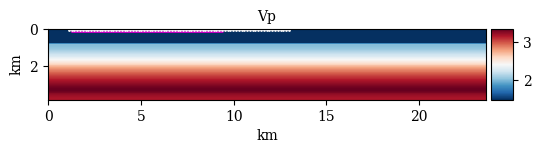

In [11]:
vp_marm_linear = ld.load_bin(f'{marm_path}marmousi_II_start_1D.vp', (500, 174))[:, 100:]
vp_marm_linear -= vmin_marm
vp_marm_linear /= vmax_marm
vp_marm_linear = box_min  + vp_marm_linear * (box_max - box_min)

vp_linear, vs_linear, rho_linear = get_vp_vs_rho(vp_marm_linear)
vis.plot_acquisition(vp_linear, dx, src, rec, title='Vp')
model_linear = api.Model(vp_linear, vs_linear, rho_linear, dx)

log_linear = vp_linear[:, log_idx]
print(model)

## Acquisition design

vp:	(152, 944), 1490.0000, 4000.0000 m/s

vs:	(152, 944), 0.0000, 2309.4011 m/s

rho:	(152, 944), 1000.0000, 2385.8122 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 23575.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


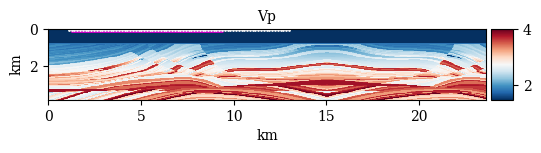

In [12]:
# Set custom wavelet
wls = bpw[:, ::2]
src.wavelets = wls[:, :dNT]

vis.plot_acquisition(vp, dx, src, rec, title='Vp')
print(model)

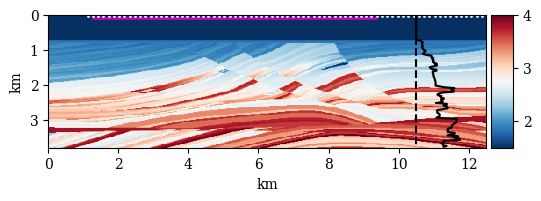

In [13]:
# Well-log location
log_loc = 10500
log = model.vp[:, log_idx]

log_dict = {'data':log/2, 'loc': log_loc}
vis.plot_acquisition(vp[:, :500], dx, src, rec, log=log_dict)

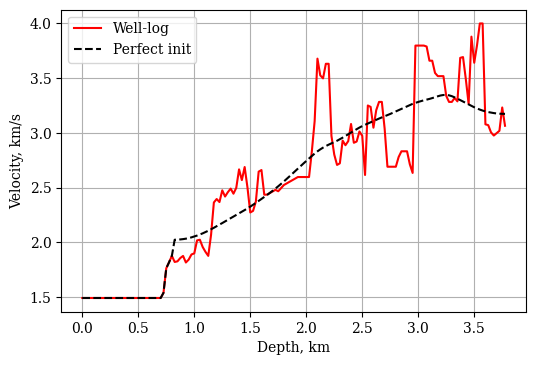

In [14]:
fig, ax = plt.subplots(1,1); 
ax_depth = np.arange(len(log)) * dx / 1000
ax.plot(ax_depth, log[::-1] / 1000, 'r', label='Well-log')
ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Perfect init')
ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')
ax.grid(True)
ax.legend()

In [15]:
print(src, end='\n\n------------\n')
print(rec)

name:	
x	(80,):	min: 1125.0	max: 12975.0
y	(80,):	min: 50.0	max: 50.0
wavelets	(80, 3000):	min: -5.2003522040678645	max: 6.286853676317875
z	(80,):	min: 0.0	max: 0.0
nshot:	80
td	(80,):	min: 0.0	max: 0.0
fc	(80,):	min: 8.0	max: 8.0
amp	(80,):	min: 1.0	max: 1.0
angle	(80,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(80,):	min: 1.0	max: 1.0

------------
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]


## Generate true waveforms

Set some runtime parameters which are different from defaults. Check defaults by runnning `help()`

In [16]:
# Elastic modeling
d.verbose = 1
d.PHYSICS = 1
d.SEISMO = 2
d.DT = dDT
d.NT = dNT
d.TIME = dDT * d.NT

d.FC_SPIKE_2 = 10
d.REC_INCR_X = dsrc
d.N_STREAMER = len(rec)

d.TESTSHOT_START = 1
d.TESTSHOT_END = len(src)
d.TESTSHOT_INCR = 10

d.QUELLTYPB = 4
d.QUELLART = 3  

d.WRITE_STF = 0

print(d.DT, d.NT)

0.002 3000


### Run forward modeling

In [17]:
print(f'Found {multiprocessing.cpu_count()} cores in your machine. Manually set "num_parallel_shots" below')

Found 56 cores in your machine. Manually set "num_parallel_shots" below


In [73]:
d.NPROCX = 1
d.NPROCY = 1

# Edit the line below to match your machine specs
num_parallel_shots = 40

par_forward = {'run_command': f'mpirun -np {num_parallel_shots}', 'disable': False}

In [76]:
if not os.path.exists(d._root_su) or not os.listdir(d._root_su):
    print(f'Create {d.save_folder} and run forward modeling...')
    d.forward(model, src, rec, **par_forward)
else:
    print(f'Synthetic seismic data already exists in {d._root_su}')

Synthetic seismic data already exists in ./pretrained_files/fwi_outputs/out_fwi_marm/su


In [70]:
# print(d.stdout)

 *******************************************************************************
 This is program DENISE Black-Edition                                           
 Parallel 2-D elastic Finite Difference FWI code                                
                                                                                
 Forward/FWI/RTM codes written by D. Koehn and D. De Nil                        
 2D isotropic PSV forward code partly based on FDVEPS written by T. Bohlen      
 Institute of Geosciences, Kiel University, Germany                           

 See README.md file and LICENSE.md for redistribution conditions.               
 *******************************************************************************

In FD_PSV MYID = 1, COLOR =0, MYID_SHOT = 1 
In FD_PSV MYID = 2, COLOR =0, MYID_SHOT = 2 
Message from PE 2
R U N - T I M E  E R R O R: 
Number of processors specified in the parameter file 
 and at command line (NP) differ !
...now exiting to system.
In FD_PSV MYID = 4,

Read 80 shots (324, 3000) into list


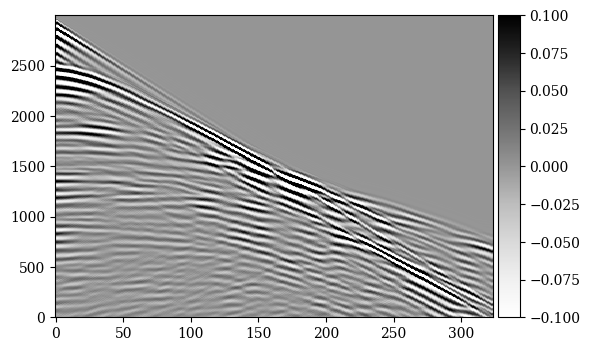

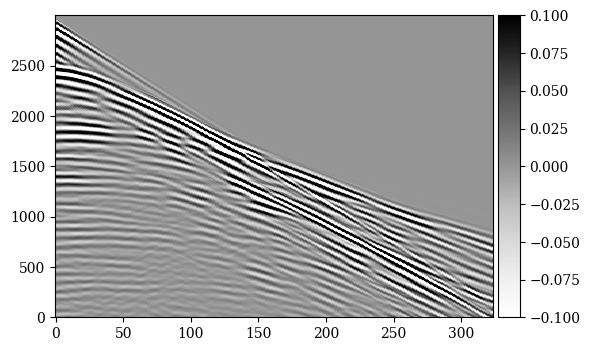

In [21]:
d.verbose = 0    # don't show redundant print outs

if d.DT is None:
    d.DT = 0.002
shots = d.get_shots(keys=['_p.'])

par_shot = {'vmin': -0.05, 'vmax': 0.05}
if shots:
    print(f'Read {len(shots)} shots {shots[0].shape} into list')
    for i in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 2)]:
        try:
            shot_s = ld.divmax(shots[i])
            vis.plot_shot(shot_s, pclip=0.1)
        except Exception as e:
            print(f'Failed to fetch data for i={i}. {e}')

In [22]:
print(src.x[48])

8325.0


### Sources

Total sources: 80
Syn wavelets:	(80, 500)	-250.17	344.49
[0, 8, 17, 26, 35, 43, 52, 61, 70, 79]


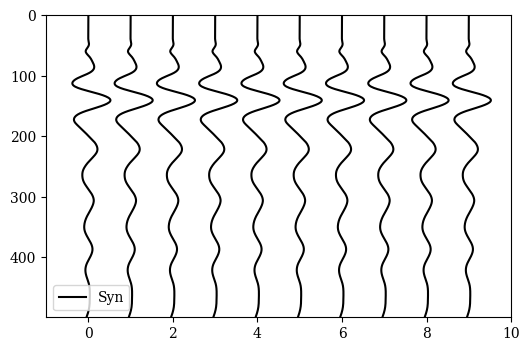

In [23]:
wavelets_s = []
for i, shot in enumerate(shots):
    no, nt = 1, 500
    wavelets_s.append(shot[:no, :nt].copy())
print(f'Total sources: {len(wavelets_s)}')
wavelets_s = np.concatenate(wavelets_s, 0)
print('Syn wavelets:\t{}\t{:.2f}\t{:.2f}'.format(wavelets_s.shape, wavelets_s.min(), wavelets_s.max()))
vis.plot_wiggles(wavelets_s, n=10, colors=['k'], legend=['Syn'])

Put all generated shots together

In [24]:
data_p = np.concatenate([np.expand_dims(s, 0) for s in shots], 0)
print(data_p.shape)

(80, 324, 3000)


### Mean and spectrum of entire dataset for FWI

(80, 324, 3000) -294.4212 344.4913


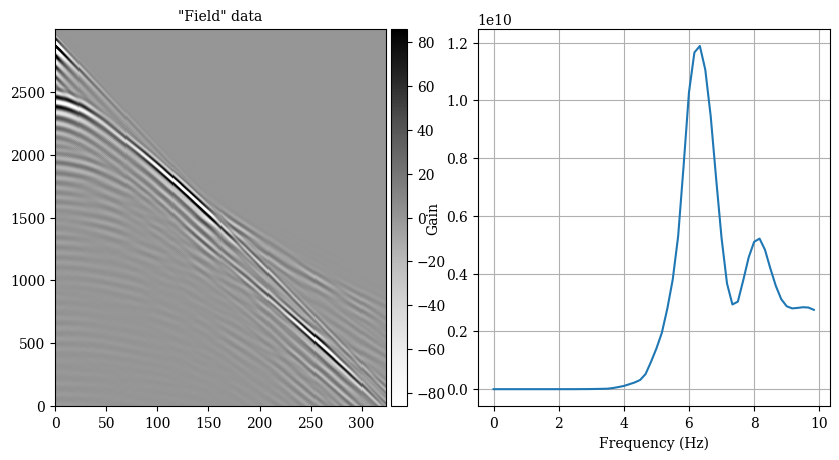

In [25]:
print(data_p.shape, data_p.min(), data_p.max())
dref = np.mean(data_p, 0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
vis.plot_shot(dref, title='"Field" data', pclip=0.25, colorbar=True, ax=ax[0])
vis.plot_spectrum(dref, dt=0.002, fmax=10, title='Spectrum', ax=ax[1])

## Reconstruct the amplitude of  the low-frequency band
We design band-pass filters so the input and target data **overlap in the range from 4 to 5 Hz**. We extract this range from available data as well as from predicted data. Then we match the predicted data with available data.

(324, 3000) -19.64588483468242 19.952956386200086


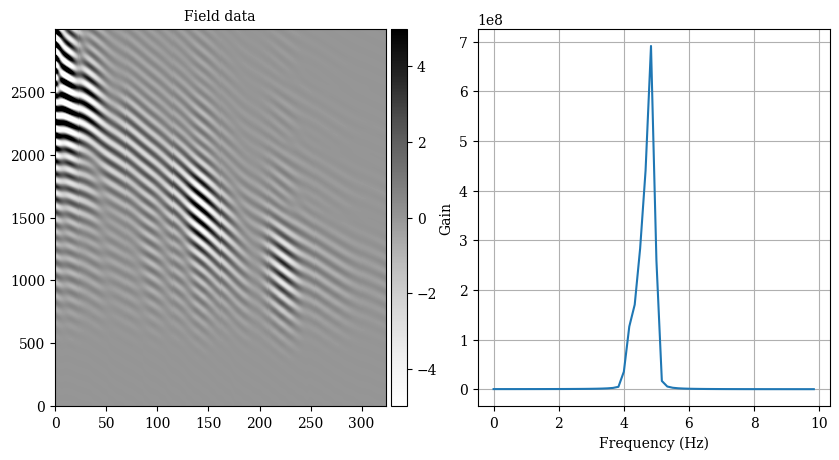

In [26]:
par_ref = {'fs': 1/0.002, 'flo': 4, 'fhi': 5, 'order': 8, 'btype': 'band'}
dref_low = ld.bandpass(dref, **par_ref)
dref_min = dref_low.min()
dref_max = dref_low.max()
print(dref_low.shape, dref_min, dref_max)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
vis.plot_shot(dref_low, title='Field data', pclip=0.25, colorbar=True, ax=ax[0])
vis.plot_spectrum(dref_low, dt=0.002, fmax=10, title='Spectrum', ax=ax[1])

### Move "field" data to a new folder inside ./su/

In [27]:
def copy_su_from_to(path_from, path_to):
    """ Copy files matching *.su.* from one folder to another folder"""
    os.makedirs(path_to, exist_ok=True)
    su_files = glob.glob(path_from + '/*.su.*')
    su_files = [f for f in su_files if '.it' not in f]
    print(f'Found {len(su_files)} *.su.* files in {path_from}')

    commands = []
    print(f'Copy files from {path_from} to {path_to}')
    for f in su_files:
        commands.append(f'cp {f} {path_to}')
    with multiprocessing.Pool() as pool:
        pool.map(os.system, commands)

In [28]:
# Make a fancy name for the built-in path
root_su_field = d._root_su + '/'

In [29]:
fnames = sd.get_fnames_pattern(root_su_field + '*.su.*')

80 files found in ./pretrained_files/fwi_outputs/out_fwi_marm/su/*.su.*


# Predict by trained DNN

Create subfolder for **predicted low frequencies** (< 5 Hz)

In [34]:
root_pred = os.path.join('/'.join(root_su_field.split('/')[:-1]), 'pred/')
copy_su_from_to(path_from=root_su_field, path_to=root_pred)

Found 80 *.su.* files in ./pretrained_files/fwi_outputs/out_fwi_marm/su/
Copy files from ./pretrained_files/fwi_outputs/out_fwi_marm/su/ to ./pretrained_files/fwi_outputs/out_fwi_marm/su/pred/


Create dataloader and cube of field data

In [35]:
fnames_low = sd.get_fnames_pattern(f'{root_pred}*.shot*')

80 files found in ./pretrained_files/fwi_outputs/out_fwi_marm/su/pred/*.shot*


In [36]:
loader_cgg, cube_cgg, scalers = sd.make_cube_and_loader(fnames)

80/80
./pretrained_files/fwi_outputs/out_fwi_marm/su/seis_p.su.shot80
(324, 3000)
Start split for (80, 324, 3000)
Start making cubes from lists for list 80, where each sublist 3
(80, 324, 376)
(80, 324, 376)
(80, 324, 376)
(80, 324, 376) (80, 324, 376) (80, 324, 376) (80, 324, 376)


Load pre-trained network. Due to silly implementation of inference I load the same network 3 times to get 3 different outputs :)

In [37]:
from utils.archs import Wrapper, Ensemble, Blend, Encoder, HeadData, HeadModel

net = Ensemble(Encoder(1), 
                     HeadData(layers=[(96, 32), (32, 16)], layers_out=(16, 1), kernel_sizes=[4, 4], strides=[2, 2], pads=[1, 1]), 
                     HeadModel(layers=[(96, 32), (32, 1)], kernel_sizes=[3, 3], strides=[1, 1]),
                     path_to_model1, 10)

Load weights for _encoder
Loading model from ./pretrained_files/trained_nets/ex5_multi_lcm_0/0_net_encoder.pth
Load weights for _data
Loading model from ./pretrained_files/trained_nets/ex5_multi_lcm_0/0_net_data.pth
Load weights for _model
Loading model from ./pretrained_files/trained_nets/ex5_multi_lcm_0/0_net_model.pth
Loading history from ./pretrained_files/trained_nets/ex5_multi_lcm_0/history_encoder.pkl...
Loading history from ./pretrained_files/trained_nets/ex5_multi_lcm_0/history_data.pkl...
Loading history from ./pretrained_files/trained_nets/ex5_multi_lcm_0/history_model.pkl...
Failed to load history form ./pretrained_files/trained_nets/ex5_multi_lcm_0/history_model.pkl, [Errno 2] No such file or directory: './pretrained_files/trained_nets/ex5_multi_lcm_0/history_model.pkl'
Loading history from ./pretrained_files/trained_nets/ex5_multi_lcm_0/history_lr.pkl...
Load sigmas from ./pretrained_files/trained_nets/ex5_multi_lcm_0
Load weights for _encoder
Loading model from ./pretrai

In [38]:
def match_amp(have, want):
    max_have = np.max(have[20:50,:-50])
    max_want = np.max(want[20:50,:-50])
    return have / max_have * max_want

## Predict low frequencies

In [39]:
def hard_blend(dat_lo, dat_hi, dt, fedge):
    assert dat_lo.shape == dat_hi.shape
    h, w = dat_lo.shape[-2:]
    dat_lo_fx = np.fft.rfft(dat_lo, w)
    dat_hi_fx = np.fft.rfft(dat_hi, w)
    ff = np.fft.rfftfreq(dat_hi.shape[-1], d=dt)

    where_left = np.where(ff < fedge)[0]
    where_right = np.where(ff >= fedge)[0]
    print(where_right.shape)
        
    dat_lo_fx[..., where_right] = dat_hi_fx[..., where_right]
    out = np.fft.irfft(dat_lo_fx, w)
    return out

In [40]:
# Bandpass filters for Low
par_blend_low_high ={'fs': 1/dt, 'upscale': 8, 'pad': (0, 8), 'flo': 4, 'btype': 'high'}

data_l = np.zeros_like(data_p)

for i,f in enumerate(fnames_low):
    clear_output()
    print(f'{i+1}/{len(fnames)}\n{f}')
    with segyio.su.open(f, "r+", endian='little', ignore_geometry=True) as dst:
        dh_cgg = loader_cgg.__getitem__(i)[0]
        
        # Predict low-frequencies and upscale it to 2 ms sampling
        lfp = signal.resample(net.predict(dh_cgg, pred_idx=0, pred_chan=1), 3000, axis=-1)
        
        # Take input data (strict zero < 4 Hz) and upsample it to 2 ms sampling
        hf = signal.resample(dh_cgg[0,...], 3000, axis=-1)
        # And match it with respective range of field data
        hf = match_amp(hf, ld.bandpass(data_p[i, ...], **par_blend_low_high))
        
        # Now extract range [4, 5] Hz and normalize low-freq prediction on it
        should_be_this = np.abs(ld.bandpass(hf, **par_ref)).max()
        got_this = np.abs(ld.bandpass(lfp, **par_ref)).max()  
        ratio = should_be_this / got_this
        lf = lfp * ratio
        print(should_be_this, got_this, ratio)
        
        data_l[i, ...] = lf 
        
        hft = data_p[i, :, :]
        blend = hard_blend(lf, hft, dt, 4)
        dst.trace = blend

80/80
./pretrained_files/fwi_outputs/out_fwi_marm/su/pred/seis_p.su.shot80
16.312527532682186 0.46212982832755434 35.29858176806536
(1477,)


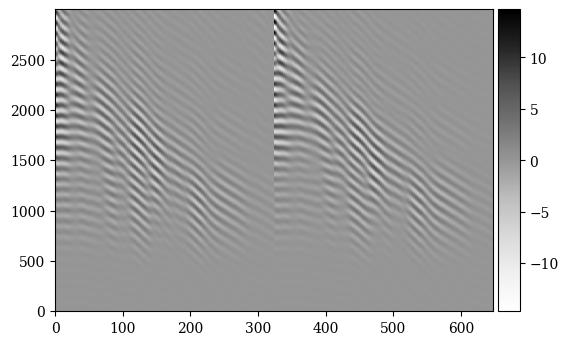

In [41]:
# Compare shared range from 4 to 5 Hz in time-offset domain
want_this = ld.bandpass(hf, **par_ref)
have_this = ld.bandpass(lf, **par_ref)
vis.plot_shot([want_this, have_this], pclip=0.9)

(80, 324, 3000)


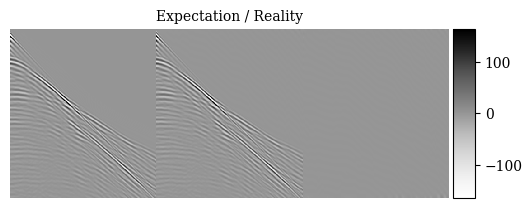

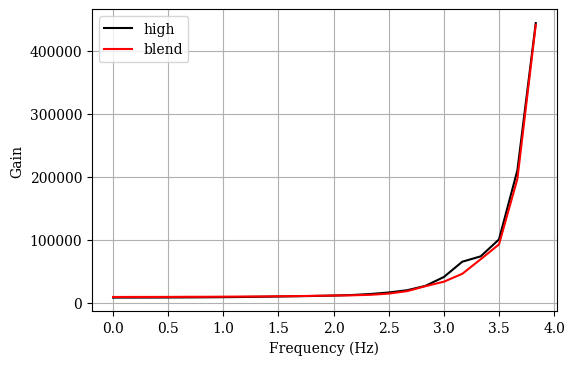

In [42]:
print(data_p.shape)
hfts = hft[:, ::8]
lfs = blend[:, ::8]
vis.plot_shot([hfts, lfs, hfts - lfs], axis=False, pclip=0.5, title='Expectation / Reality')

# Plot data and spectra
dictlist = [
           {'data': hft, 'line': 'k', 'label': 'high'},
           {'data': blend, 'line': 'r', 'label': 'blend'},
           ]

vis.plot_spectra_dictlist(dictlist, dt=dt, fmax=4)

(80, 324, 3000)
Low true (324, 3000)
	min:	-3.156913e+01	max:	2.987572e+01
Low predicted (324, 3000)
	min:	-3.046579e+01	max:	3.161683e+01


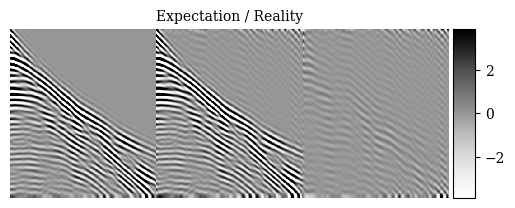

In [43]:
# Expected ideal low frequencies
print(data_p.shape)
lft = ld.bandpass(data_p[i, :, :], fs=1/dt, fhi=5, btype='low', order=8)
lfs = ld.bandpass(blend, fs=1/dt, fhi=5, btype='low', order=8)

print('Low true {}\n\tmin:\t{:e}\tmax:\t{:e}'.format(lft.shape, lft.min(), lft.max()))
print('Low predicted {}\n\tmin:\t{:e}\tmax:\t{:e}'.format(lfs.shape, lfs.min(), lfs.max()))

lfts = lft[..., ::8]
lfss = lfs[..., ::8]
# lfs_match = match_amp(lfts, lfs)
vis.plot_shot([lfts, lfss, lfts - lfss], axis=False, pclip=0.125, title='Expectation / Reality')

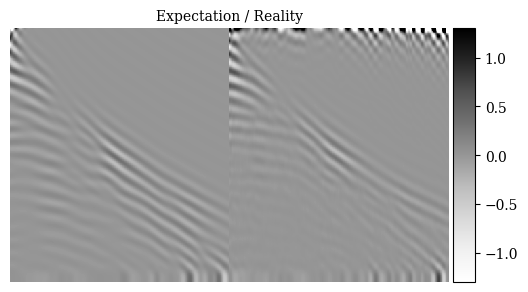

In [44]:
vis.plot_shot([ld.bandpass(lft, fs=1/dt, fhi=3, btype='low', order=8)[..., ::8], 
               ld.bandpass(lfs, fs=1/dt, fhi=3, btype='low', order=8)[..., ::8]], 
              axis=False, pclip=0.125, title='Expectation / Reality')

## Predict initial model

In [45]:
from skimage.transform import resize
pred = np.zeros((len(fnames), *dh_cgg.shape[-2:]))
for i, f in enumerate(fnames):
    clear_output()
    print(f'{i+1}/{len(fnames)}\n{f}')
    with segyio.su.open(f, "r+", endian='little', ignore_geometry=True) as dst:
        dh_cgg = loader_cgg.__getitem__(i)[0]
        p = resize(net.predict(dh_cgg, pred_idx=1, pred_chan=0), dh_cgg.shape[-2:])
        p += 1
        p /= 2
        p *= (box_max - box_min)
        p += box_min
        pred[i, ...] = p

80/80
./pretrained_files/fwi_outputs/out_fwi_marm/su/seis_p.su.shot80


In [46]:
print(pred.shape)
ndsrc = int(dsrc // dx)
print(ndsrc, dh_cgg.shape)
shp = dh_cgg.shape[-2:]

(80, 324, 376)
6 (1, 324, 376)


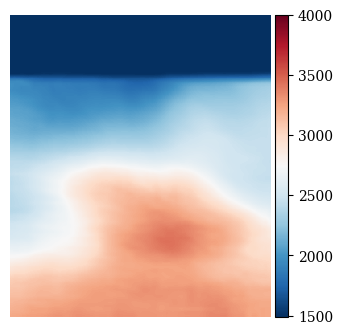

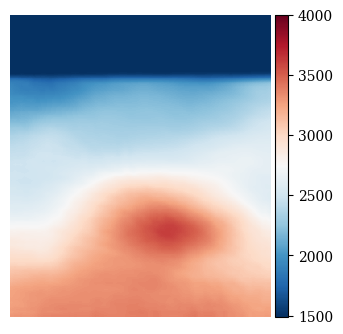

In [47]:
mpl.rcParams['figure.dpi']= 100
for i in range(0, pred.shape[0], 50):
     vis.plot_shot(pred[i, ...], cmap='RdBu_r', vmin=box_min, vmax=box_max, axis=False)

(798, 376)
(798, 376)


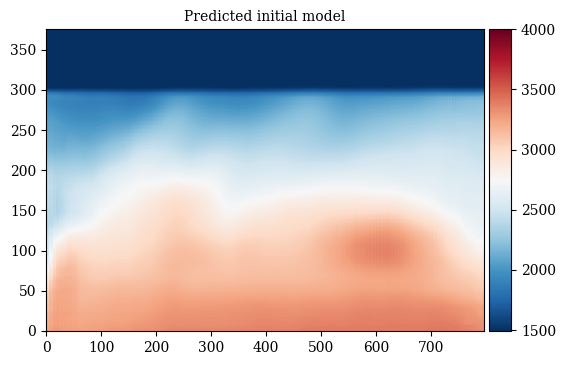

In [48]:
pred_model = np.zeros((shp[0] + (len(fnames)-1)*ndsrc, shp[-1]))
print(pred_model.shape)
overlaps = np.zeros_like(pred_model)
print(overlaps.shape)
for i in range(len(fnames)):
    pred_model[ndsrc*i:ndsrc*i+dh_cgg.shape[-2], :] += pred[i,...]
    overlaps[ndsrc*i:ndsrc*i+dh_cgg.shape[-2], :] += 1
pred_model = pred_model / overlaps
vis.plot_shot(pred_model, cmap='RdBu_r', vmin=box_min, vmax=box_max, title='Predicted initial model')

In [49]:
print(vp.max(), vp.min())
print(pred_model.shape, model.vp.shape)

4000.0 1490.0
(798, 376) (152, 944)


In [50]:
from scipy import signal, ndimage

# Rotate to be aligned with modeling domain
vp_net = np.flipud(pred_model.T)
print(vp_net.shape)

# Want this sizes
want_nz = model.vp.shape[0] # stretch to become like what used for forward modeling
want_nx = vp_net.shape[-1]  # keep same dim along offset axis

# Actual resize
vp_net = resize(vp_net.astype(np.float32), (want_nz, want_nx))
print(vp_net.shape)

(376, 798)
(152, 798)


In [51]:
idx_src_0 = int(src.x[0] // dx)
print(f'First source at {idx_src_0}')

# Embed prediction into placeholder
vp_p = np.zeros_like(model.vp)
print(vp_p.shape, vp_net.shape)
idx_end = min(vp_net.shape[-1], vp_p.shape[-1])
idx_crop = min(idx_src_0, 0)
vp_p[:, idx_src_0:idx_src_0+idx_end] = vp_net[:, :idx_end-idx_crop]

# Fill left padding
left_pad = idx_src_0 + int(0.75 * idx_src_0)
print(f'Mirror data till xid = {left_pad}')
vp_p[:, :left_pad] = np.flip(vp_p[:, left_pad:2*left_pad], -1)


# Fill right padding
right_pad = int(0.2 * vp_p.shape[-1])
print(f'Mirror data till xid = {right_pad}')
vp_p[:, -right_pad:] = np.flip(vp_p[:, -2*right_pad:-right_pad], -1)

First source at 45
(152, 944) (152, 798)
Mirror data till xid = 78
Mirror data till xid = 188


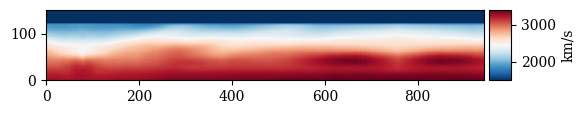

In [52]:
vis.plot_model(vp_p)

### Crop extended model (only needed for first forward modeling)

In [53]:
wb_taper = np.where(model.vp < 1.01 * model.vp.min(), 1, 0)
nx0 = 500
nz0 = model.vp.shape[0]
limits_vp = {'vmin': model.vp.min() / 1000, 'vmax': model.vp.max() / 1000}
limits_vs = {'vmin': model.vs.min() / 1000, 'vmax': model.vs.max() / 1000}
limits_rho = {'vmin': model.rho.min() / 1000, 'vmax': model.rho.max() / 1000}

(152, 944) 1490.0 3407.01513671875


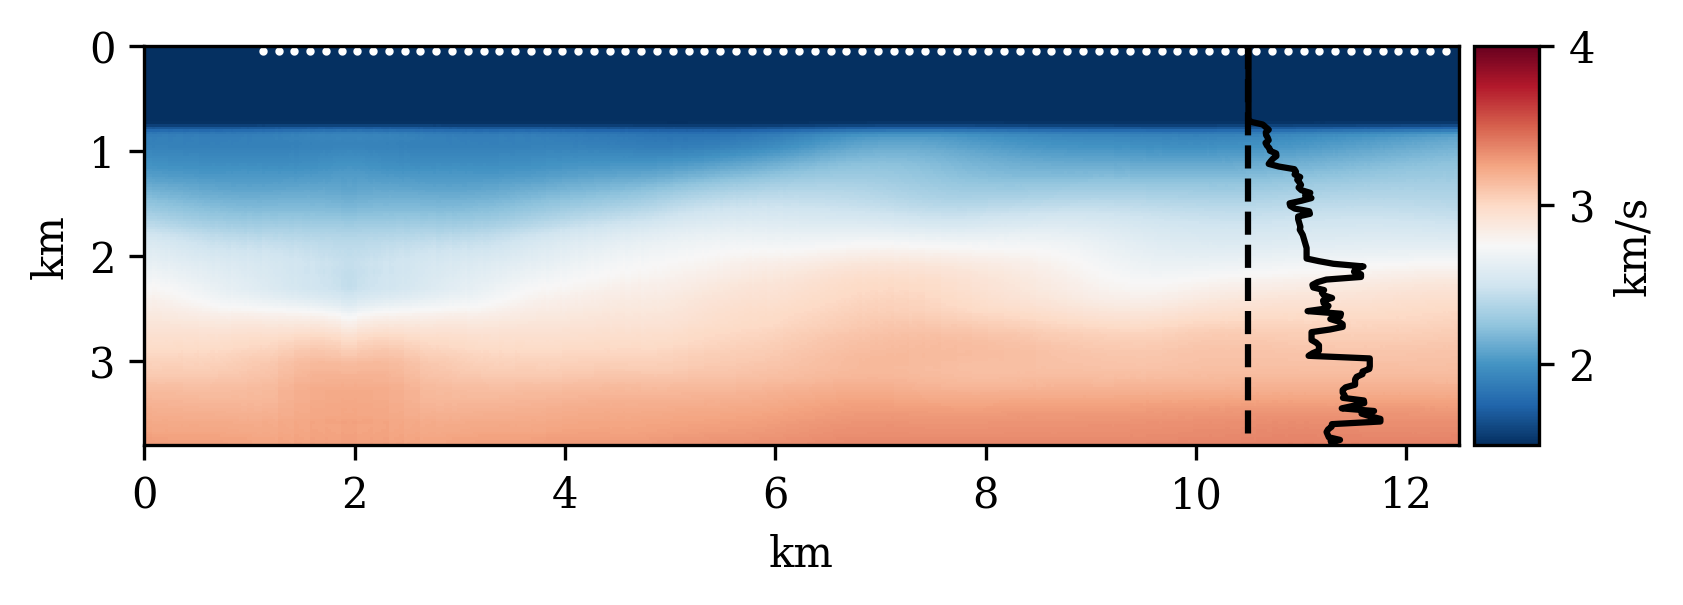

In [54]:
vp_p[wb_taper.astype(bool)] = model.vp[wb_taper.astype(bool)]
vs_p = vp_p.copy() / (3 ** 0.5)
vs_p = np.where(vp_p < 1.01 * np.min(vp_p), 0, vs_p)

# density, [kg/m3] 
rho_p = 1e3*0.3 * vp_p.copy()**0.25
rho_p = np.where(vp_p < 1.01 * np.min(vp_p), 1000, rho_p)

mpl.rcParams['figure.dpi']= 300
vis.plot_log_model(vp_p, dx, nx0, nz0, src, log=log / 2, log_location=log_loc, **limits_vp)
mpl.rcParams['figure.dpi']= 100
print(vp_p.shape, vp_p.min(), vp_p.max())

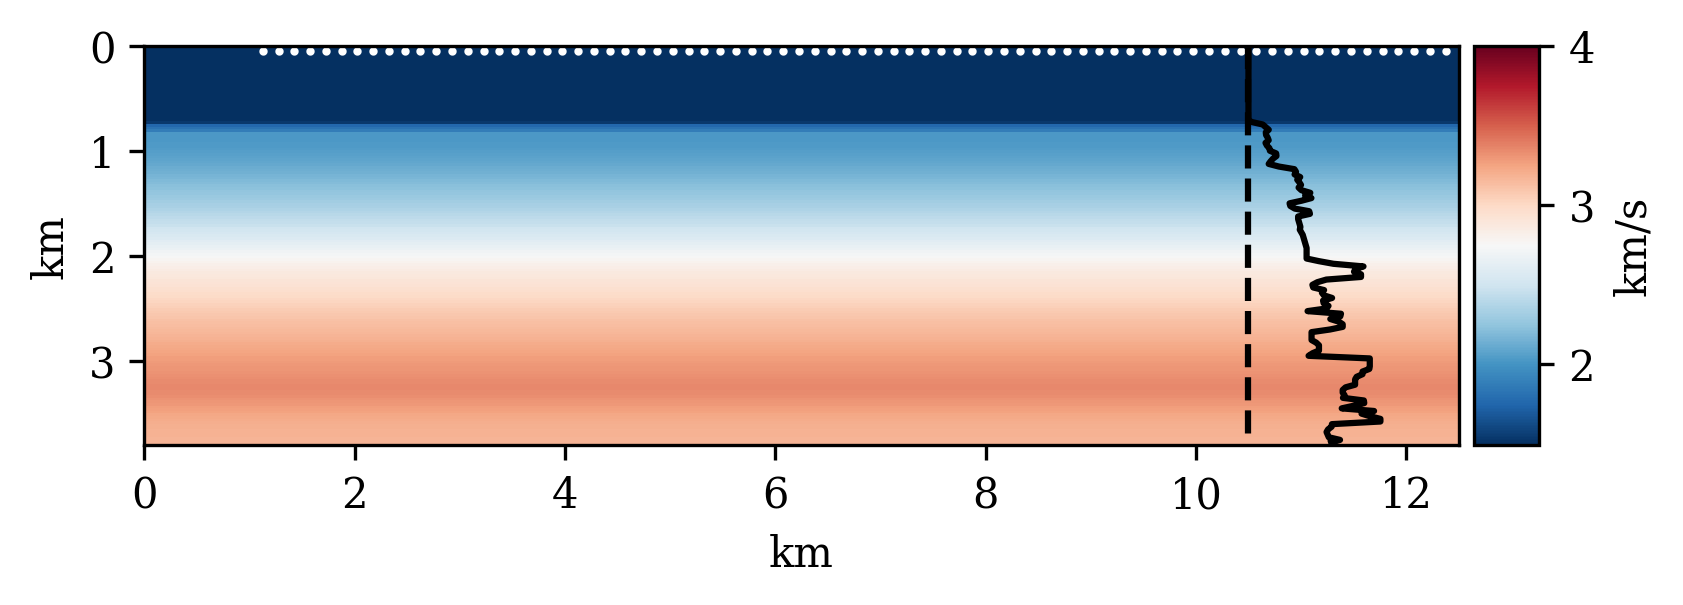

In [55]:
mpl.rcParams['figure.dpi']= 300
vis.plot_log_model(vp_linear, dx, nx0, nz0, src, log=log / 2, log_location=log_loc, **limits_vp)
mpl.rcParams['figure.dpi']= 100

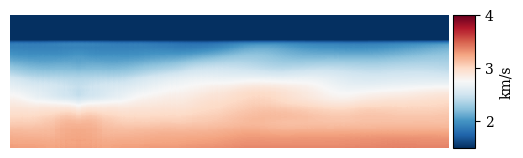

In [56]:
# importlib.reload(vis)
vis.plot_log_model(vp_p, dx, nx0, nz0, axis=False, **limits_vp)

## Crop predicted model
Large part of the model (beyond last source) was only to get full-offset seismic data. When running inversion it is not needed so we cut it down

In [57]:
xcut = 672
wb_taper = wb_taper[:, :xcut]
model_init = api.Model(vp_p[:, :xcut], vs_p[:, :xcut], rho_p[:, :xcut], dx)
print(model_init)

vp:	(152, 672), 1490.0000, 3400.8044 m/s

vs:	(152, 672), 0.0000, 1963.4554 m/s

rho:	(152, 672), 1000.0000, 2290.9556 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 16775.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


# Full-waveform inversion
Invert for elastic properties `vp`, `vs` and `rho`, given `x` and `y` velocity components of wavefield 

## Initial velocity model
Smooth background model with true water bottom and shallow sediments

152 (152, 672) 152


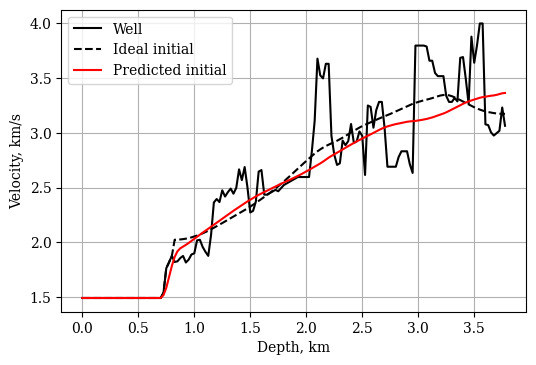

In [58]:
# ax = plot_model(np.concatenate((model_init.vp, model_init.vs, model_init.rho), 1))
# plot_logs(model_log, model_init, log_idx)

fig, ax = plt.subplots(1,1); 
# ax_depth = np.arange(len(wlog)) * dx / 1000
ax_depth = np.arange(len(log_linear)) * dx / 1000
ax.plot(ax_depth, log[::-1] / 1000, 'k', label='Well')
ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Ideal initial')

# log_pred = model_init.vp[-len(wlog):, log_idx]

log_pred = model_init.vp[-len(log):, log_idx]
wlog = log_pred
ax.plot(ax_depth, log_pred[::-1] / 1000, 'r', label='Predicted initial')

nwater = 33#33
dummy = np.zeros_like(model.vp)
dummy[-nwater:, :] = 1.
log_taper = np.min(log_pred) + dummy[:, log_idx] * (np.max(log_pred) - np.min(log_pred))
log_taper = np.min(log_pred) + wb_taper[-len(wlog):, log_idx] * (np.max(log_pred) - np.min(log_pred))
# ax.plot(ax_depth, log_taper[::-1]  / 1000, 'b', label='Taper')
# 
# ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Linear')
ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')
ax.grid(True)
ax.legend()

print(len(wlog), model_init.vp.shape, len(model_init.vp[:len(wlog)]))

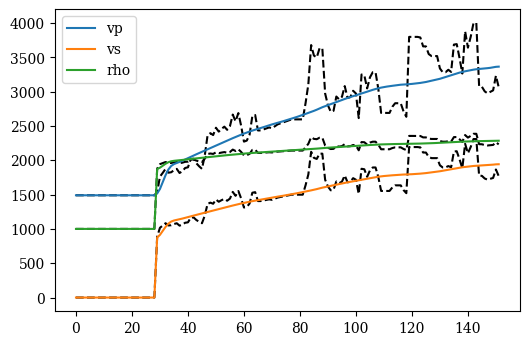

In [59]:
vis.plot_logs(model, model_init, log_idx)

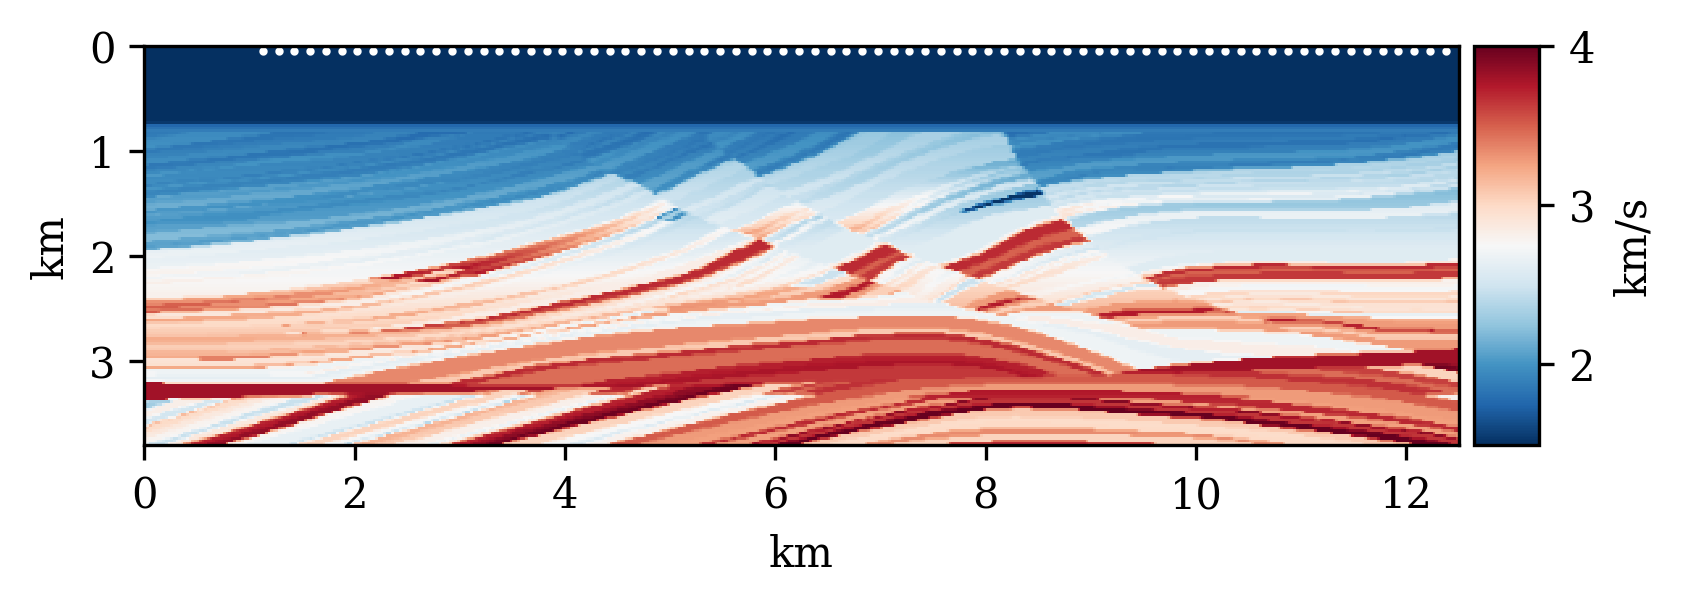

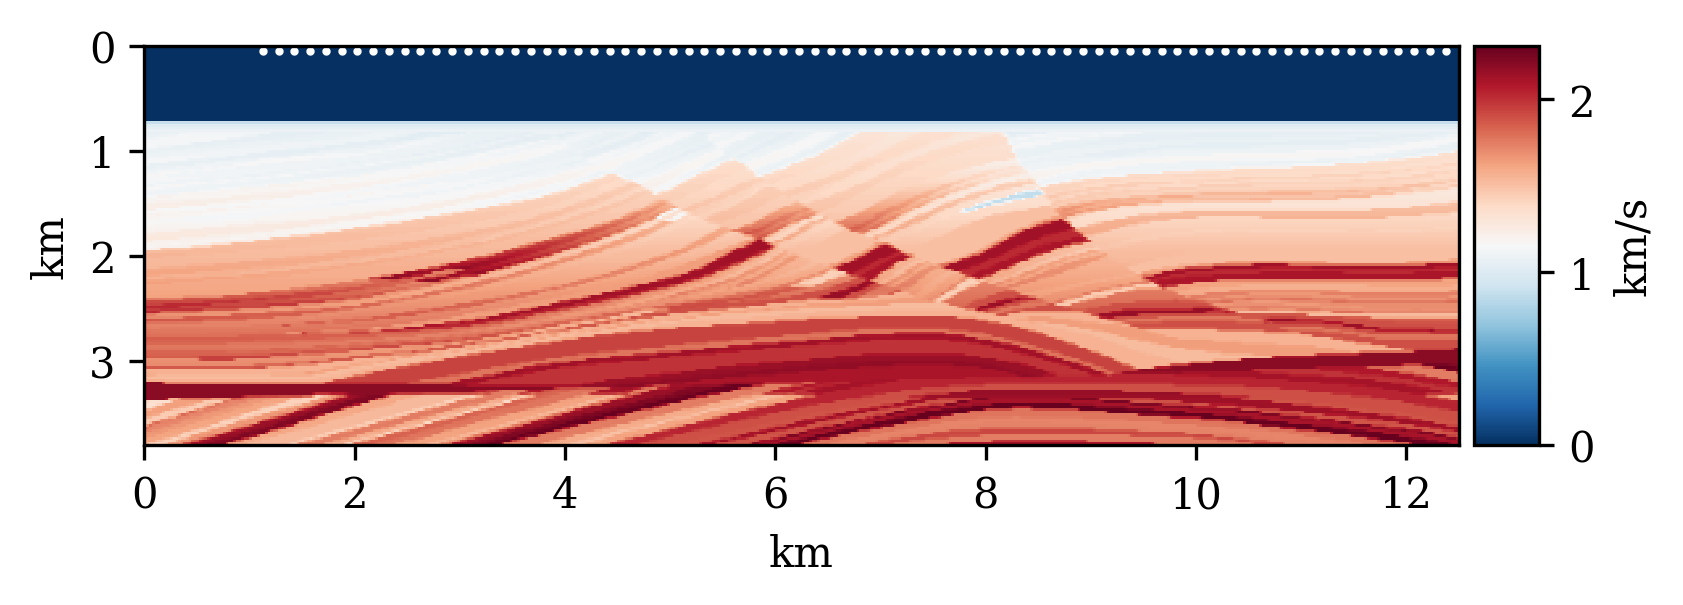

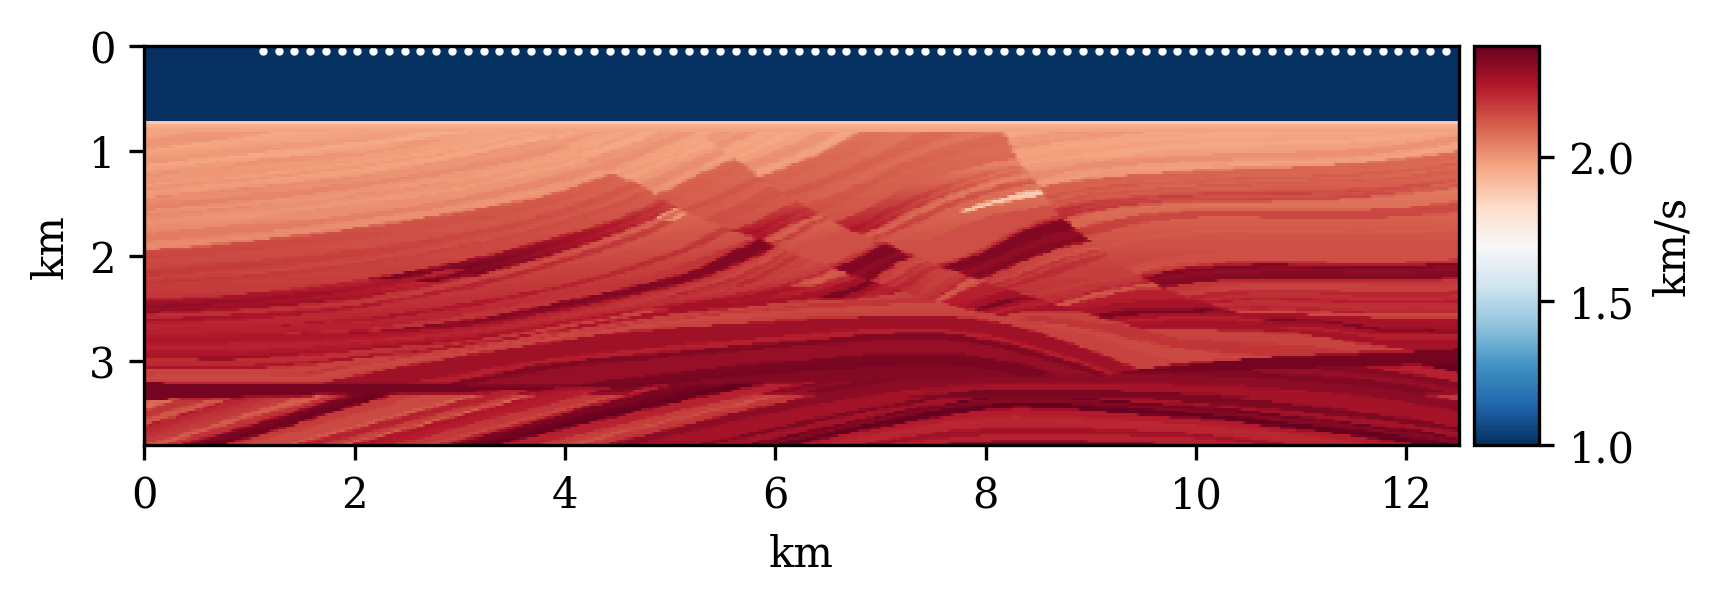

In [60]:
mpl.rcParams['figure.dpi']= 300
vis.plot_log_model(model.vp, dx, nx0, nz0, src, **limits_vp)
vis.plot_log_model(model.vs, dx, nx0, nz0, src, **limits_vs)
vis.plot_log_model(model.rho, dx, nx0, nz0, src, **limits_rho)
mpl.rcParams['figure.dpi']= 100

## Stages of inversion
Use default parameters, except high- and low-pass corner frequencies of Butterworth filter

In [61]:
d.SWS_TAPER_GRAD_HOR = 1
d.GRADT1, d.GRADT2 = 25, 30

(152, 672) (152, 672)
Save (672, 152) as binary to ./pretrained_files/fwi_outputs/out_fwi_marm/taper/taper.bin
Save (672, 152) as binary to ./pretrained_files/fwi_outputs/out_fwi_marm/taper/taper_u.bin
Save (672, 152) as binary to ./pretrained_files/fwi_outputs/out_fwi_marm/taper/taper_rho.bin


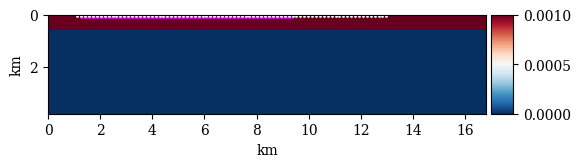

In [62]:
# import loaders as ld
# # Gradient tapering
# d.SWS_TAPER_GRAD_VERT = 0
# d.SWS_TAPER_GRAD_HOR = 0
# d.SWS_TAPER_CIRCULAR_PER_SHOT = 0   # enable grad tapering around sources

d.VPUPPERLIM = 4000.
d.VPLOWERLIM = np.min(model_init.vp)
d.VSUPPERLIM = 2500.
d.VSLOWERLIM = np.min(model_init.vs)
d.RHOUPPERLIM = 2500.
d.RHOLOWERLIM = np.min(model_init.rho)

d.SWS_TAPER_FILE = 1

taper = np.zeros_like(model_init.vp)
print(taper.shape,wb_taper.shape)
shift = 4
taper[shift:, :] = wb_taper[:-shift,:] # water mask

if d.SWS_TAPER_FILE:
    os.makedirs(d._root_tapers, exist_ok=True)
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_u.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_rho.bin'))
    vis.plot_acquisition(taper, dx, src, rec)

In [63]:
par_stages_fwi = {'inv_vs_iter': 0,
                 'inv_rho_iter': 0,
                 'normalize': 2,
                 'order': 6,
                 }

d.fwi_stages = []
freqs_high = [3, 4, 5, 6, 7, 8]
grad_smoothing = [2, 1.5, 1.0, 0.5, 0.25, 0.125]
spatfilters = [4, 4, 0, 0, 0, 0]
for i, freq in enumerate(freqs_high):
    d.add_fwi_stage(fc_high=freq, 
                    wd_damp=grad_smoothing[i],
                    wd_damp1=grad_smoothing[i],
                    spatfilter=spatfilters[i],
                    **par_stages_fwi)
    print(f'Stage {i+1}:\n\t{d.fwi_stages[i]}\n')

Stage 1:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 3, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-': 0.0, 'TWIN+': 0.0, 'INV_VP_ITER': 0, 'INV_VS_ITER': 0, 'INV_RHO_ITER': 0, 'INV_QS_ITER': 0, 'SPATFILTER': 4, 'WD_DAMP': 2, 'WD_DAMP1': 2, 'EPRECOND': 3, 'LNORM': 2, 'ROWI': 0, 'STF_INV': 0, 'OFFSETC_STF': -4.0, 'EPS_STF': 0.1, 'NORMALIZE': 2, 'OFFSET_MUTE': 0, 'OFFSETC': 10, 'SCALERHO': 0.5, 'SCALEQS': 1.0, 'ENV': 1, 'N_ORDER': 0}

Stage 2:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 4, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-': 0.0, 'TWIN+': 0.0, 'INV_VP_ITER': 0, 'INV_VS_ITER': 0, 'INV_RHO_ITER': 0, 'INV_QS_ITER': 0, 'SPATFILTER': 4, 'WD_DAMP': 1.5, 'WD_DAMP1': 1.5, 'EPRECOND': 3, 'LNORM': 2, 'ROWI': 0, 'STF_INV': 0, 'OFFSETC_STF': -4.0, 'EPS_STF': 0.1, 'NORMALIZE': 2, 'OFFSET_MUTE': 0, 'OFFSETC': 10, 'SCALERHO': 0.5, 'SCALEQS': 1.0, 'ENV': 1, 'N_ORDER': 0}

Stage 3:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 5, 'ORDER': 6, 'TIME_WIN':

## Run inversion

In [64]:
d.WRITE_STF = 0
d.NPROCX = 8
d.NPROCY = 2
d.verbose = 1

# Set disable to False if you actually want to run FWI on local machine.
# The disabled version writes parameter and model files but does not run modeling.  
par_fwi_runtime = {'run_command': 'mpirun -np 32', 'disable': True}

In [65]:
# Set target data for inversion in the folder with predicted data
d.DATA_DIR = f'{root_fwi}su/pred/seis'
print(f'Target data: {d.DATA_DIR}')

Target data: ./pretrained_files/fwi_outputs/out_fwi_marm/su/pred/seis


In [66]:
d.verbose = 1
d.fwi(model_init, src, rec, **par_fwi_runtime)

Target data: ./pretrained_files/fwi_outputs/out_fwi_marm/su/pred/seis
Create FWI workflow file in ./pretrained_files/fwi_outputs/out_fwi_marm/seis_fwi.inp
Init model:
	152 x 672, dx = 25.0 m
Check max source frequency:
	min Vs: 868.8561961321279 m/s
	min Vp: 1490.0 m/s
	Number of gridpoints per minimum wavelength = 3.69
	Maximum source wavelet frequency = 9.418495351025777 Hz
Check domain decomposition for parallelization:
	in X-direction, NX % NPROCX, 672 % 8 = 0
	in Y-direction, NY % NPROCY, 152 % 2 = 0
Write ./pretrained_files/fwi_outputs/out_fwi_marm/start/model.vp
Write ./pretrained_files/fwi_outputs/out_fwi_marm/start/model.vs
Write ./pretrained_files/fwi_outputs/out_fwi_marm/start/model.rho
Custom taper from taper.bin (vp), taper_u.bin (vs) and taper_rho.bin (rho)
Enable streamer mode!
	source 1: ./pretrained_files/fwi_outputs/out_fwi_marm/receiver/receivers_shot_1
	source 2: ./pretrained_files/fwi_outputs/out_fwi_marm/receiver/receivers_shot_2
	source 3: ./pretrained_files/fwi_

	wavelet 16: ./pretrained_files/fwi_outputs/out_fwi_marm/wavelet/wavelet_shot_16.dat
	wavelet 17: ./pretrained_files/fwi_outputs/out_fwi_marm/wavelet/wavelet_shot_17.dat
	wavelet 18: ./pretrained_files/fwi_outputs/out_fwi_marm/wavelet/wavelet_shot_18.dat
	wavelet 19: ./pretrained_files/fwi_outputs/out_fwi_marm/wavelet/wavelet_shot_19.dat
	wavelet 20: ./pretrained_files/fwi_outputs/out_fwi_marm/wavelet/wavelet_shot_20.dat
	wavelet 21: ./pretrained_files/fwi_outputs/out_fwi_marm/wavelet/wavelet_shot_21.dat
	wavelet 22: ./pretrained_files/fwi_outputs/out_fwi_marm/wavelet/wavelet_shot_22.dat
	wavelet 23: ./pretrained_files/fwi_outputs/out_fwi_marm/wavelet/wavelet_shot_23.dat
	wavelet 24: ./pretrained_files/fwi_outputs/out_fwi_marm/wavelet/wavelet_shot_24.dat
	wavelet 25: ./pretrained_files/fwi_outputs/out_fwi_marm/wavelet/wavelet_shot_25.dat
	wavelet 26: ./pretrained_files/fwi_outputs/out_fwi_marm/wavelet/wavelet_shot_26.dat
	wavelet 27: ./pretrained_files/fwi_outputs/out_fwi_marm/wavelet/

In [67]:
d.set_model(model_init)
d.verbose=0
print(d.save_folder)

Init model:
	152 x 672, dx = 25.0 m
./pretrained_files/fwi_outputs/out_fwi_marm/


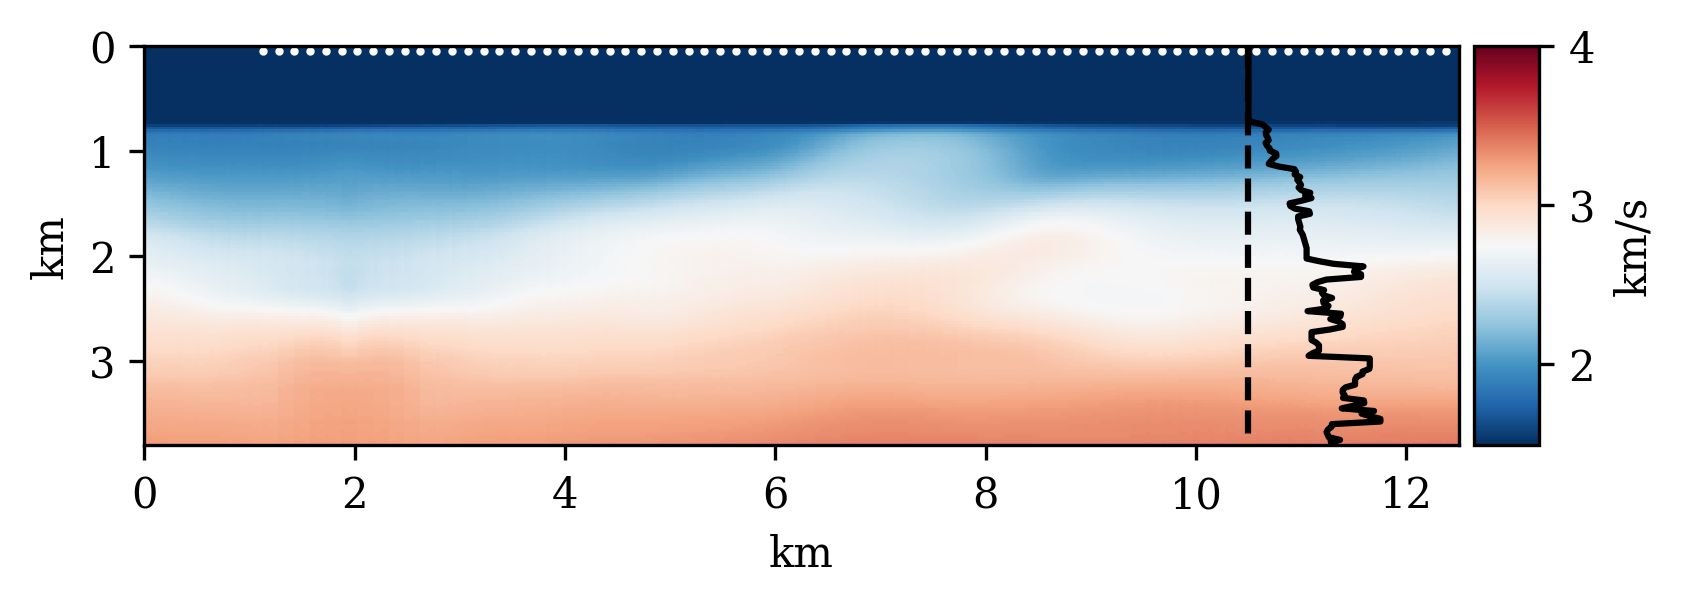

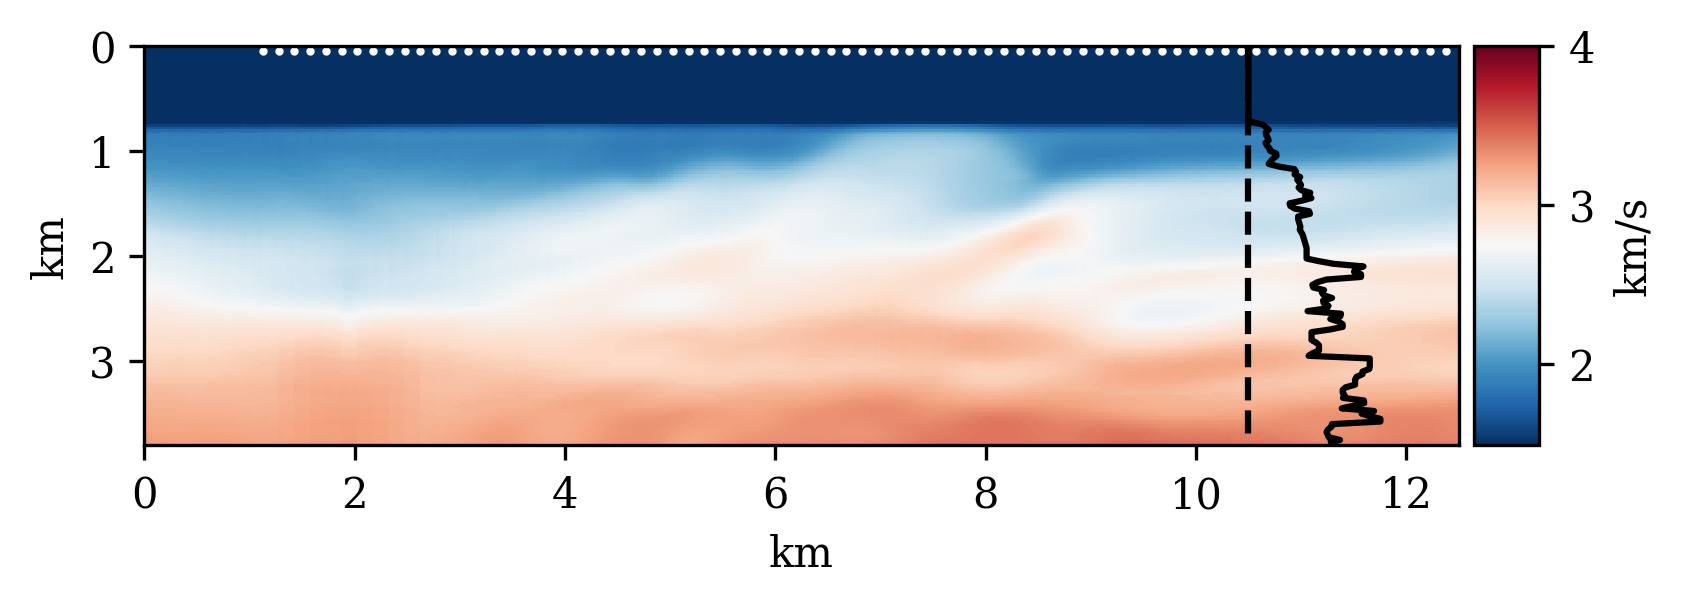

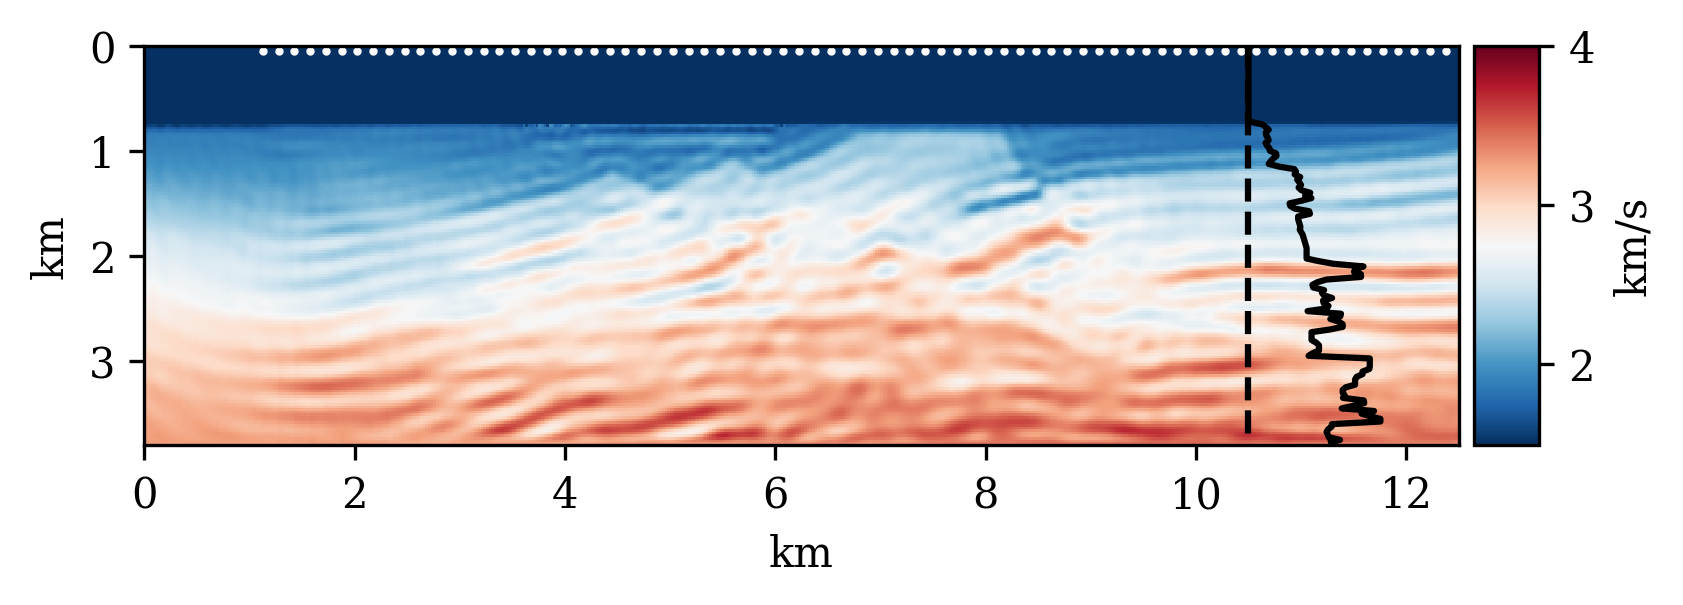

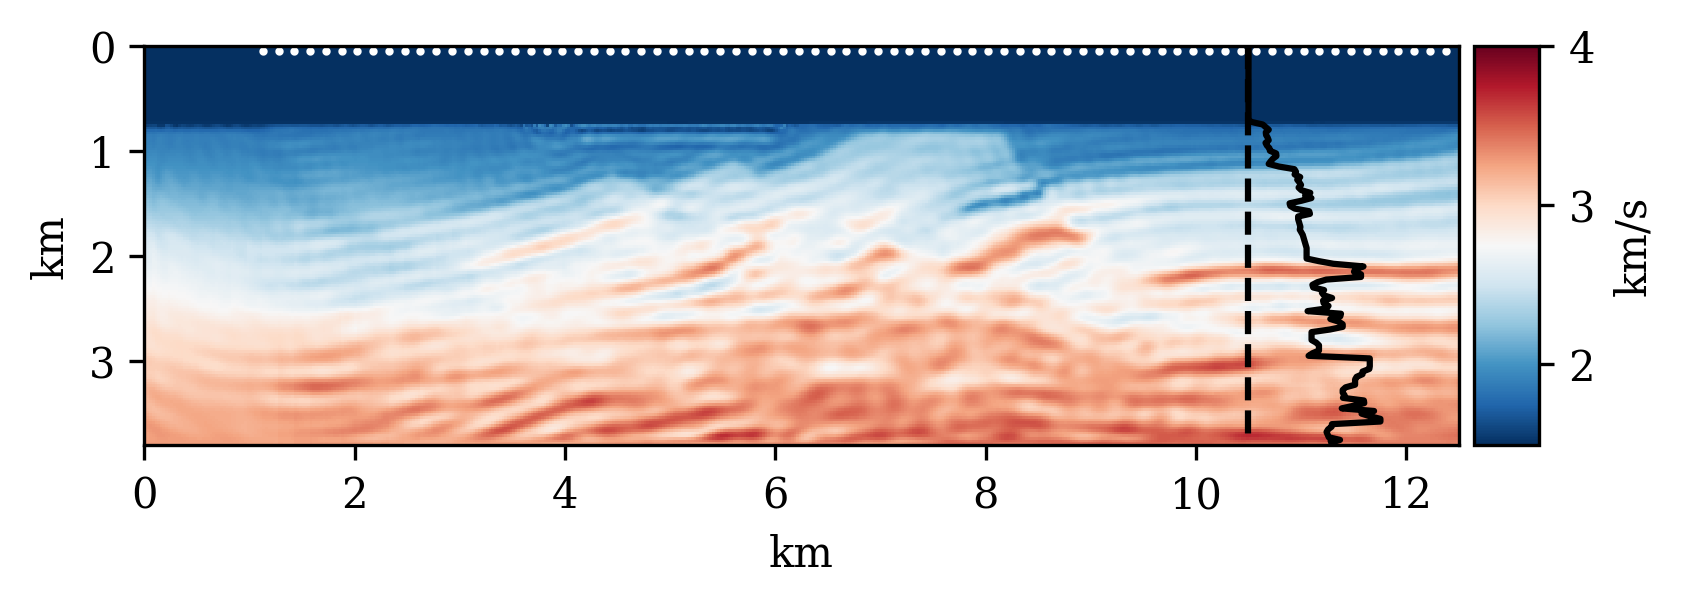

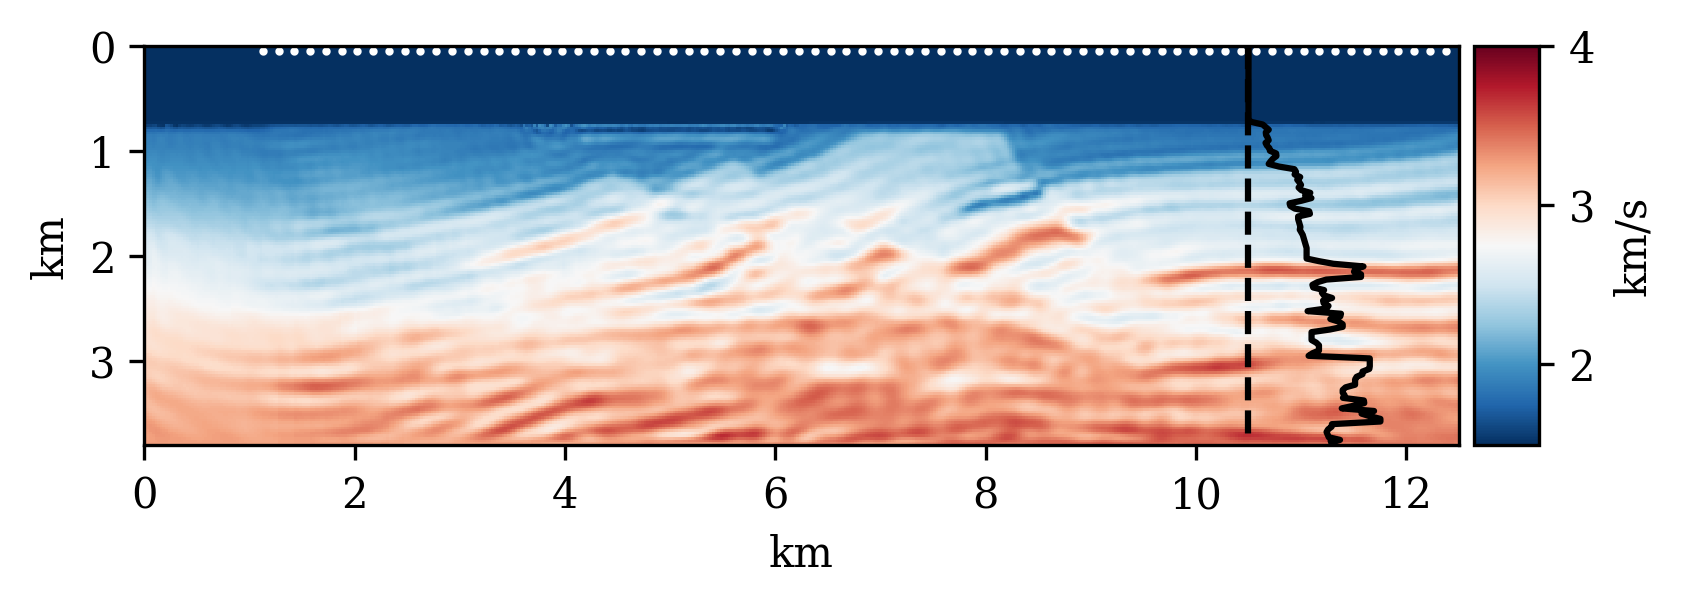

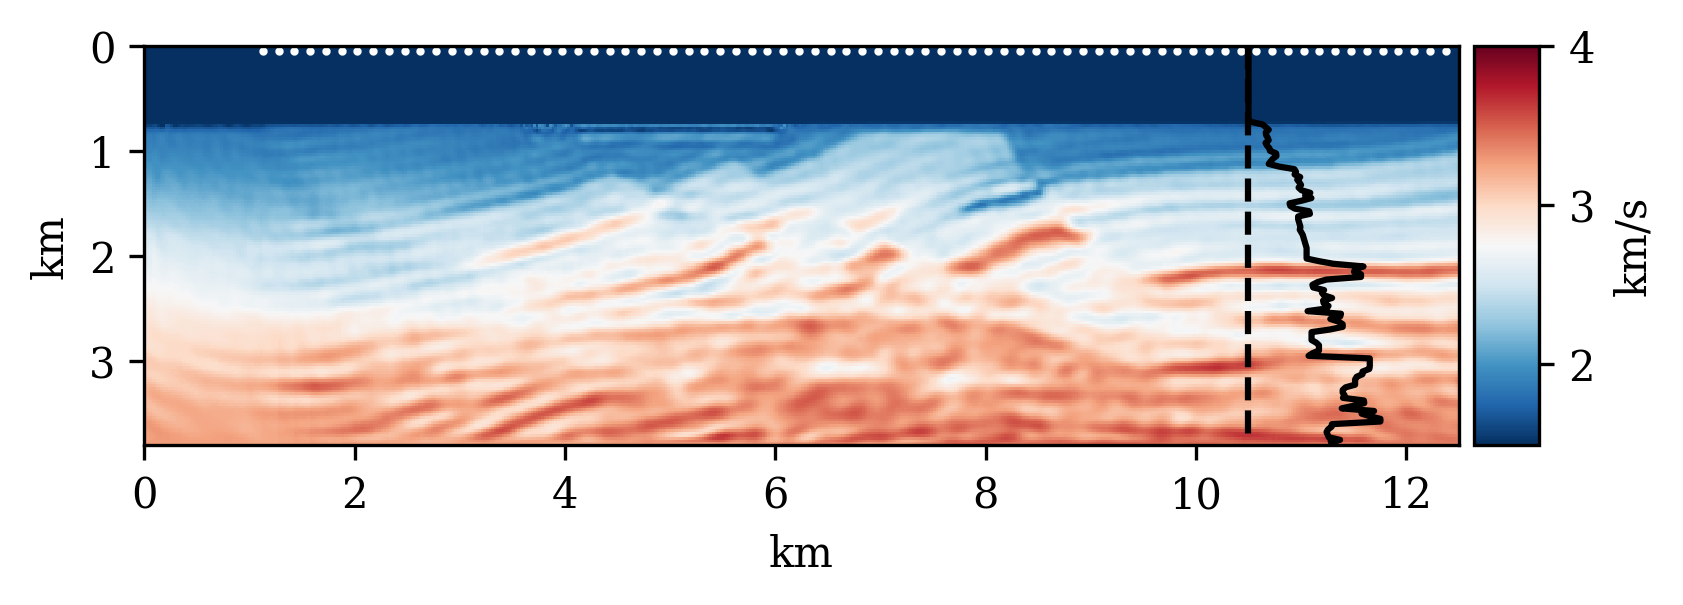

In [68]:
mpl.rcParams['figure.dpi']= 300
models, fnames = d.get_fwi_models(['vp_stage'], return_filenames=True)
for m, f in zip(models, fnames):
    vis.plot_log_model(m, dx, nx0, nz0, src, log=log / 2, log_location=log_loc, **limits_vp)
mpl.rcParams['figure.dpi']= 100

### Plot latest

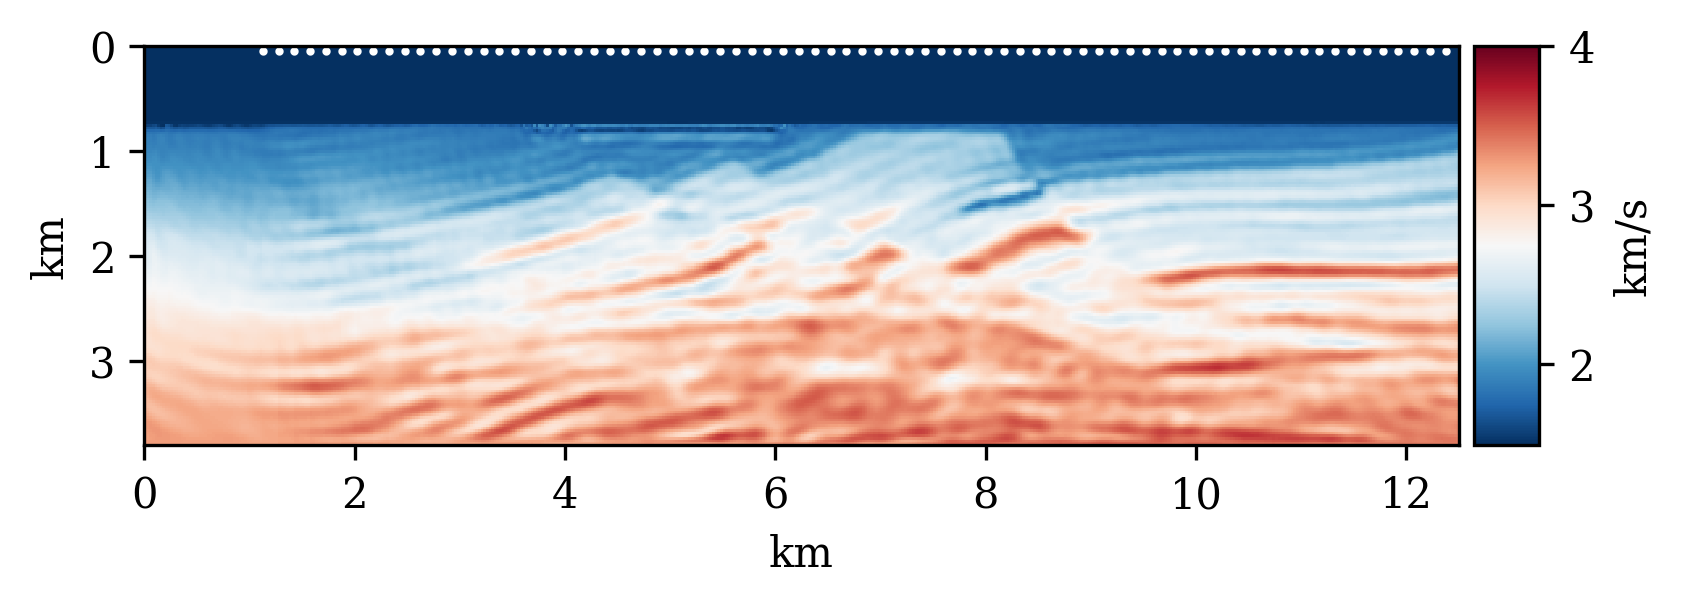

In [67]:
mpl.rcParams['figure.dpi']= 300
models, fnames = d.get_fwi_models(['vp_stage'], return_filenames=True)
for m, f in zip(models[-1:], fnames[-1:]):
    vis.plot_log_model(m, dx, nx0, nz0, src, **limits_vp)
mpl.rcParams['figure.dpi']= 100

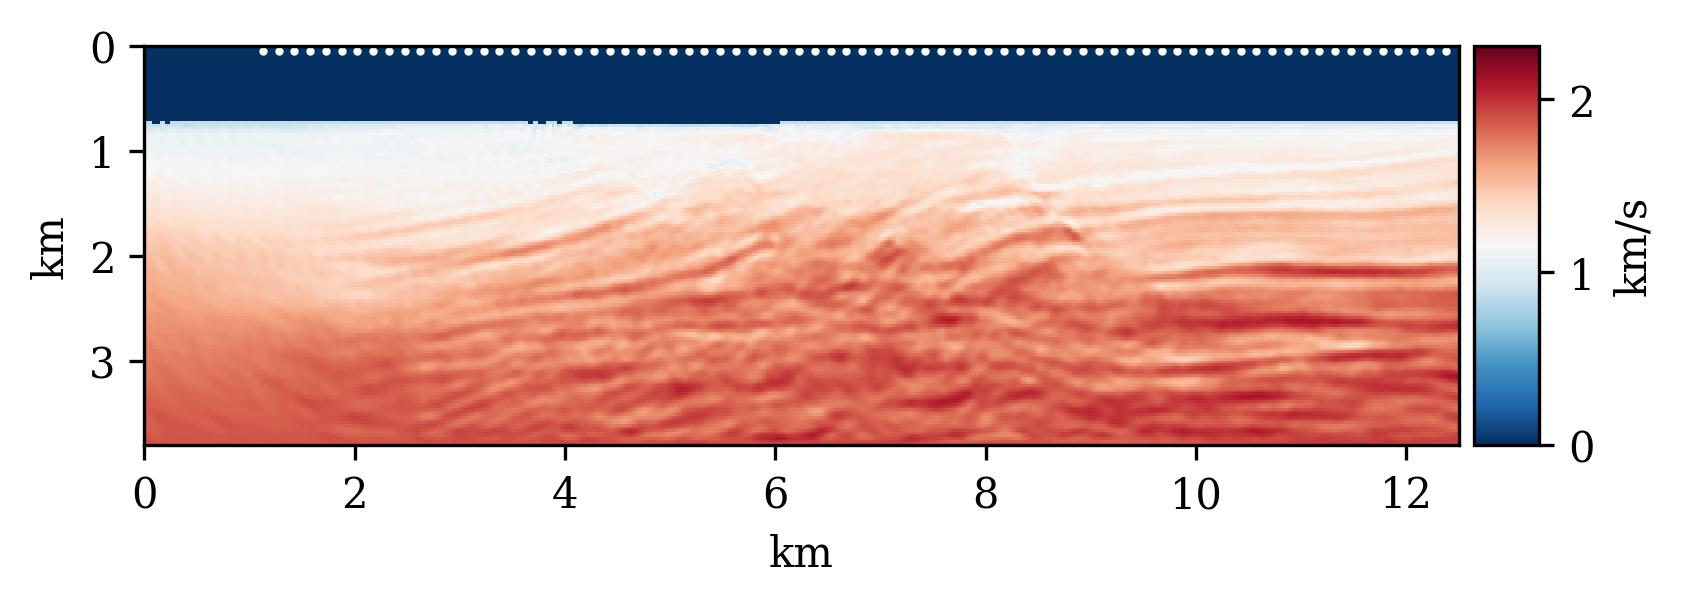

In [68]:
mpl.rcParams['figure.dpi']= 300
models, fnames = d.get_fwi_models(['vs_stage'], return_filenames=True)
for m, f in zip(models[-1:], fnames[-1:]):
    vis.plot_log_model(m, dx, nx0, nz0, src, **limits_vs)
mpl.rcParams['figure.dpi']= 100

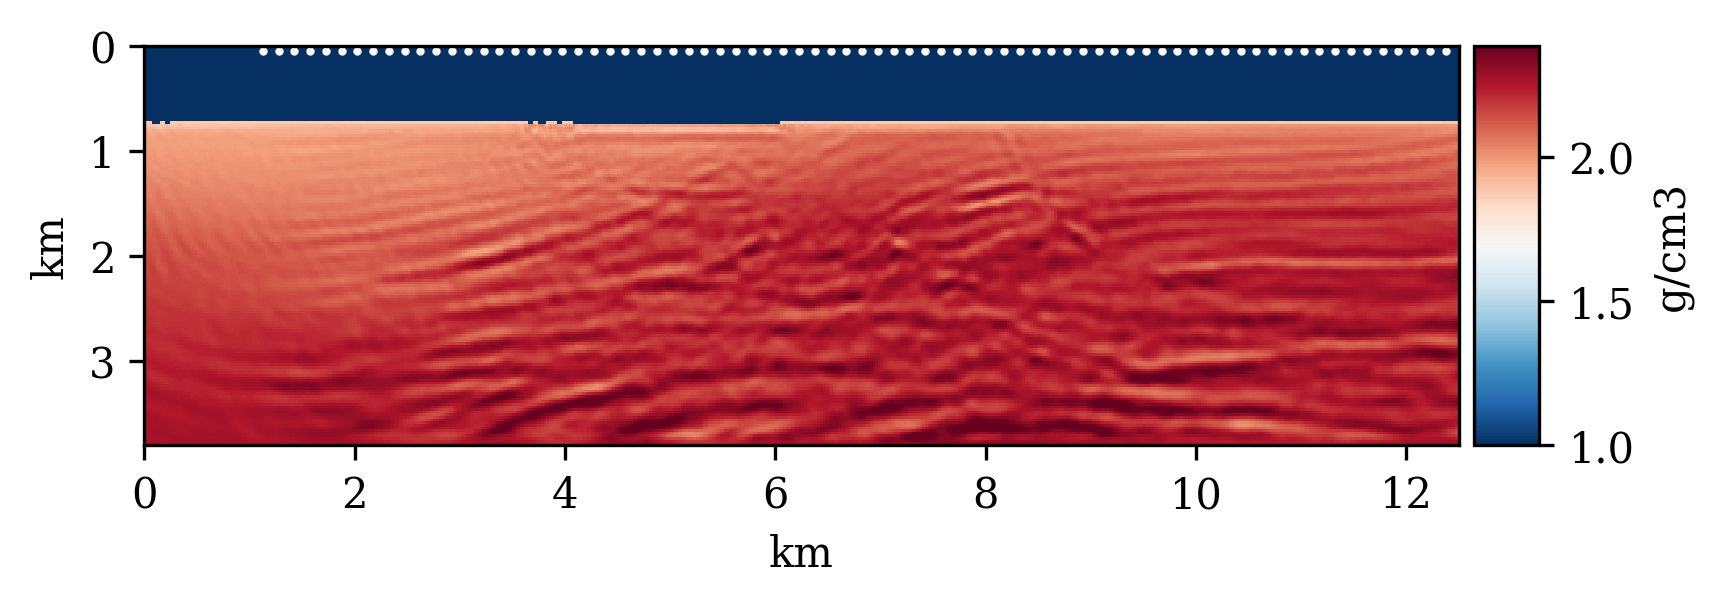

In [69]:
importlib.reload(vis)
mpl.rcParams['figure.dpi']= 300
models, fnames = d.get_fwi_models(['rho_stage'], return_filenames=True)
for m, f in zip(models[-1:], fnames[-1:]):
    vis.plot_log_model(m, dx, nx0, nz0, src, cax_label='g/cm3', **limits_rho)
mpl.rcParams['figure.dpi']= 100

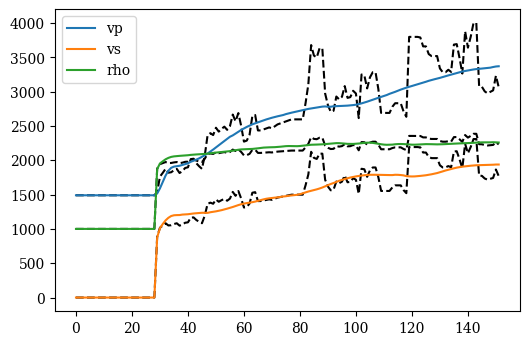

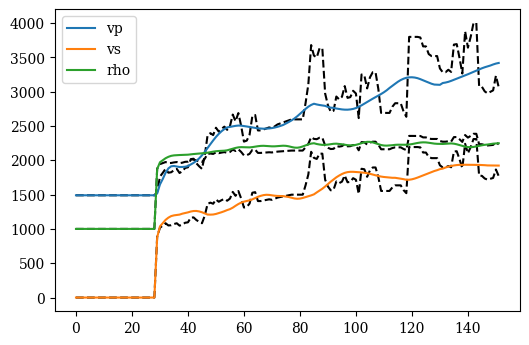

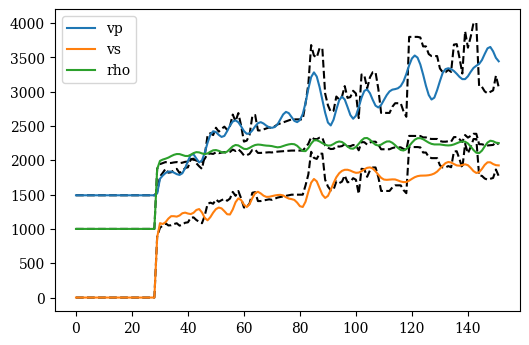

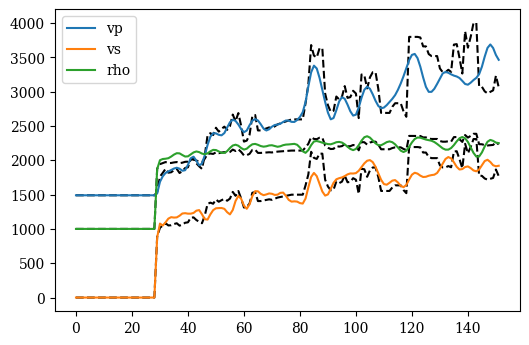

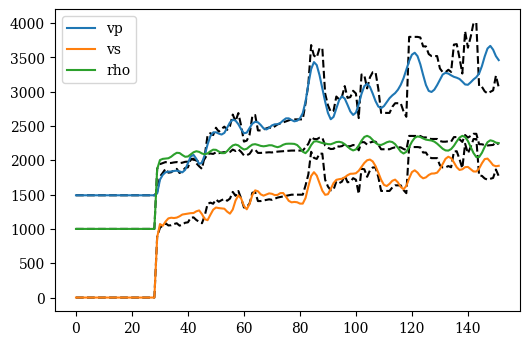

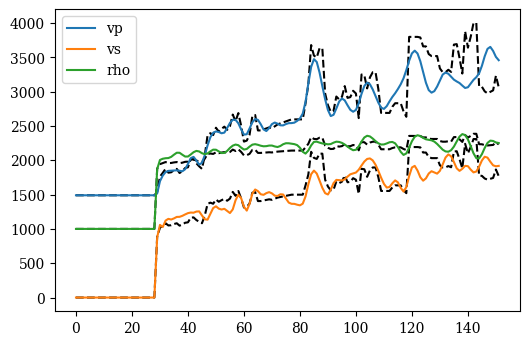

In [70]:
# Load inverted models from all stages
vvr = {'vp': None, 'vs': None, 'rho': None}
for k in vvr.keys():
    vvr[k], fnames = d.get_fwi_models([k + '_stage'], return_filenames=True)

for i in range(len(vvr['vp'])):
    vis.plot_logs(model, api.Model(vvr['vp'][i], vvr['vs'][i], vvr['rho'][i], dx), log_idx)

### Gradients

In [71]:
# d.verbose = 0
# grads, fnames = d.get_fwi_gradients(return_filenames=True)
# for g, f in zip(grads, fnames):
#     plot_model(g, f)

## Vp

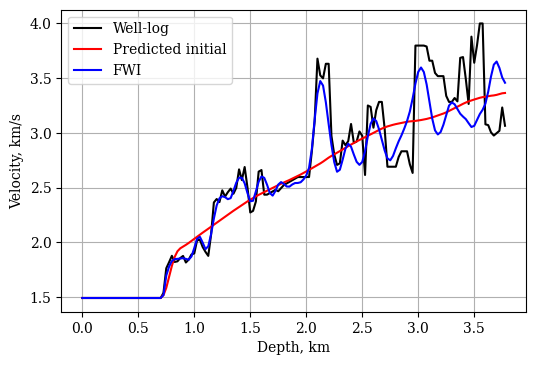

In [72]:
fig, ax = plt.subplots(1,1); 
ax_depth = np.arange(len(log)) * dx / 1000
ax.plot(ax_depth, log[::-1] / 1000, 'k', label='Well-log')

log_pred = model_init.vp[-len(log):, log_idx]
ax.plot(ax_depth, log_pred[::-1] / 1000, 'r', label='Predicted initial')

log_inv = vvr['vp'][-1][-len(log):, log_idx]
ax.plot(ax_depth, log_inv[::-1] / 1000, 'b', label='FWI')

ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')
ax.grid(True)
ax.legend()

## Vs

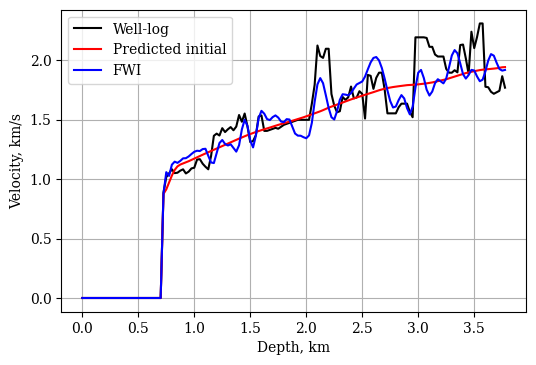

In [73]:
fig, ax = plt.subplots(1,1); 
ax_depth = np.arange(len(log)) * dx / 1000
vs_log = model.vs[:, log_idx]
ax.plot(ax_depth, vs_log[::-1] / 1000, 'k', label='Well-log')

log_pred = model_init.vs[-len(log):, log_idx]
ax.plot(ax_depth, log_pred[::-1] / 1000, 'r', label='Predicted initial')

log_inv = vvr['vs'][-1][-len(log):, log_idx]
ax.plot(ax_depth, log_inv[::-1] / 1000, 'b', label='FWI')

ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')
ax.grid(True)
ax.legend()

## Rho

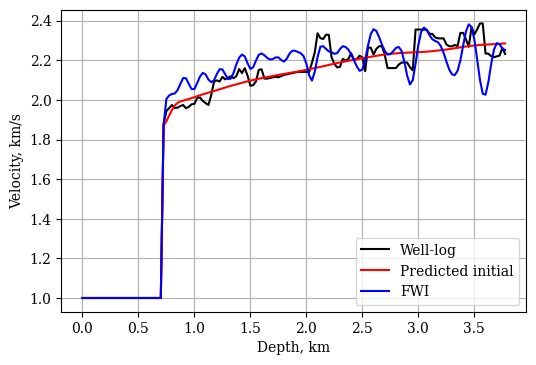

In [74]:
fig, ax = plt.subplots(1,1); 
ax_depth = np.arange(len(log)) * dx / 1000
rho_log = model.rho[:, log_idx]
ax.plot(ax_depth, rho_log[::-1] / 1000, 'k', label='Well-log')

log_pred = model_init.rho[-len(log):, log_idx]
ax.plot(ax_depth, log_pred[::-1] / 1000, 'r', label='Predicted initial')

log_inv = vvr['rho'][-1][-len(log):, log_idx]
ax.plot(ax_depth, log_inv[::-1] / 1000, 'b', label='FWI')

ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')
ax.grid(True)
ax.legend()

# Compare wavefiedls before/after

In [75]:
vps, fnames = d.get_fwi_models(['vp_stage'], return_filenames=True)
vss, fnames = d.get_fwi_models(['vs_stage'], return_filenames=True)
rhos, fnames = d.get_fwi_models(['rho_stage'], return_filenames=True)

if vps:
    model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    print(f'Found last model at {fnames[-1]}')
else:
    print(f'Not found the inverted model in {d.save_folder}!')

Found last model at ./pretrained_files/fwi_outputs/out_fwi_marm/model/modelTest_rho_stage_6.bin


In [76]:
d.save_folder = root_fwi[:-1] + '_wavefield/'
print(f'{root_fwi[:-1]} --> {d.save_folder}')

./pretrained_files/fwi_outputs/out_fwi_marm --> ./pretrained_files/fwi_outputs/out_fwi_marm_wavefield/


In [84]:
d.NPROCX = 1
d.NPROCY = 1
if not os.path.exists(d._root_su) or not os.listdir(d._root_su):
    print(f'Create {d.save_folder} and run forward modeling...')
    d.forward(model, src, rec, **par_forward)
else:
    print(f'Synthetic seismic data already exists in {d._root_su}')

Create ./pretrained_files/out_fwi_marm_wavefield/ and run forward modeling...
mpirun -np 40 ../den/bin/denise  ./pretrained_files/out_fwi_marm_wavefield/seis.inp ./pretrained_files/out_fwi_marm_wavefield/seis_fwi.inp

Done. 68.97908926010132 sec.

Check results in ./pretrained_files/out_fwi_marm_wavefield/su/


## Intervaled comparison of data

Read 80 shots (324, 3000) into list


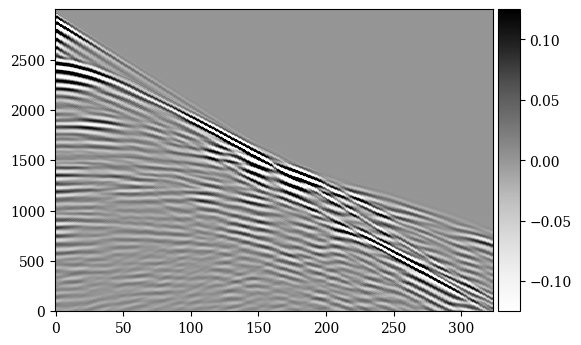

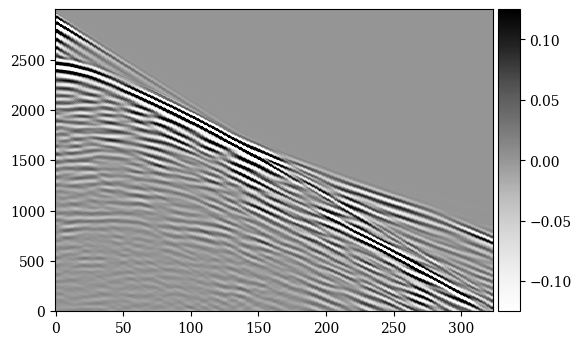

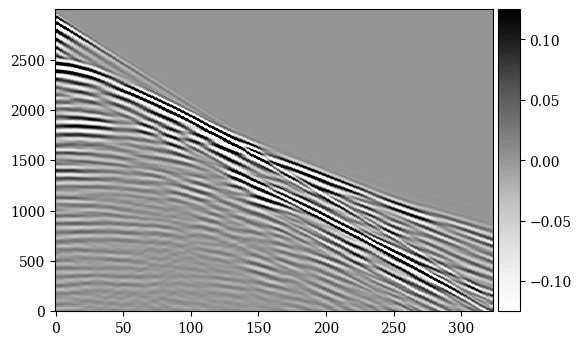

In [86]:
d.verbose = 0    # don't show redundant print outs

if d.DT is None:
    d.DT = 0.002
shots = d.get_shots(keys=['_p'])
# shots = [ld.bandpass(s, fs=1./(d.DT * d.NDT), **par_bp) for s in d.get_shots(keys=['_p'])]
print(f'Read {len(shots)} shots {shots[0].shape} into list')

for ishot in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 3)]:
    shot_s = ld.divmax(shots[ishot])
    shot_f = ld.divmax(data_p[ishot, :, ::d.NDT])
#     vis.plot_shot(np.concatenate([np.flip(shot_s, 0), shot_f], axis=0), pclip=0.125)
    vis.plot_compare_stripes(shot_s, shot_f, pclip=0.125)